In [4]:
pip install skforecast

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


### Dependencies

In [6]:
# Import libraries 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

#Import pmdarima
import pmdarima as pm
from pmdarima import ARIMA
from pmdarima import auto_arima

#Import stats models
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
from typing import Union
from tqdm import tqdm_notebook

#Import skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import plotly.graph_objects as go

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

%matplotlib inline

In [7]:
# Import data 
data = pd.read_csv('combined_data.csv')
etf_data = pd.DataFrame(data)
etf_data.head()

,Date,IXN,VNQ,XLE,XLF,XLY,Sentiment Text,Sentiment Value,Sentiment Lag_1,Sentiment Lag_2,...,Sentiment Lag_4,Sentiment Lag_5,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF
0,2014-01-01,12.641662,42.107735,58.413666,14.477487,58.956947,negative,-1.0,-1.0,-1.0,...,-1.0,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
1,2014-01-02,12.486846,42.114258,57.582096,14.398009,58.683434,negative,-1.0,-1.0,-1.0,...,-1.0,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
2,2014-01-03,12.436762,42.349052,57.370922,14.497356,58.524654,negative,-1.0,-1.0,-1.0,...,-1.0,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
3,2014-01-06,12.406402,42.564293,57.450108,14.510599,58.162983,negative,-1.0,-1.0,-1.0,...,-1.0,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
4,2014-01-07,12.489882,42.753437,57.885685,14.517219,58.515846,negative,-1.0,-1.0,-1.0,...,-1.0,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07


In [10]:
etf_data.columns

Index(['Date', 'IXN', 'VNQ', 'XLE', 'XLF', 'XLY', 'Sentiment Text',
       'Sentiment Value', 'Sentiment Lag_1', 'Sentiment Lag_2',
       'Sentiment Lag_3', 'Sentiment Lag_4', 'Sentiment Lag_5', 'GDPC1',
       'CPIAUCSL', 'UNRATE', 'PAYEMS', 'RRSFS', 'GFDEBTN', 'VIXCLS', 'DFF'],
      dtype='object')

In [12]:
etf_data = etf_data.drop(labels = ['Sentiment Value', 
                                   'Sentiment Lag_1', 
                                   'Sentiment Lag_2',
                                   'Sentiment Lag_3', 
                                   'Sentiment Lag_4', 
                                   'Sentiment Lag_5'], axis = 1)

etf_data

,Date,IXN,VNQ,XLE,XLF,XLY,Sentiment Text,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF
0,2014-01-01,12.641662,42.107735,58.413666,14.477487,58.956947,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
1,2014-01-02,12.486846,42.114258,57.582096,14.398009,58.683434,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
2,2014-01-03,12.436762,42.349052,57.370922,14.497356,58.524654,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
3,2014-01-06,12.406402,42.564293,57.450108,14.510599,58.162983,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
4,2014-01-07,12.489882,42.753437,57.885685,14.517219,58.515846,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,2024-10-07,81.199997,94.269997,93.510002,45.090000,195.089996,positive,22924.863000,314.121,4.2,158779.0,226274.0,3.483163e+07,16.15,4.83
2809,2024-10-08,82.669998,94.459999,91.070000,45.349998,196.990005,positive,22924.863000,314.121,4.2,158779.0,226274.0,3.483163e+07,16.15,4.83
2810,2024-10-09,83.650002,94.559998,91.620003,45.770000,198.399994,positive,22924.863000,314.121,4.2,158779.0,226274.0,3.483163e+07,16.15,4.83
2811,2024-10-10,83.360001,93.720001,92.239998,45.630001,197.419998,positive,22924.863000,314.121,4.2,158779.0,226274.0,3.483163e+07,16.15,4.83


In [14]:
# Import SPY index data
spy = yf.download('SPY', start = '2014-01-01', end = '2024-10-12')
spy['Date'] = spy.index
spy = spy.reset_index(drop=True)
spy = spy[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
spy.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,183.979996,184.070007,182.479996,182.919998,151.242950,119636900
1,2014-01-03,183.229996,183.600006,182.630005,182.889999,151.218140,81390600
2,2014-01-06,183.490005,183.559998,182.080002,182.360001,150.779938,108028200
3,2014-01-07,183.089996,183.789993,182.949997,183.479996,151.705872,86144200
4,2014-01-08,183.449997,183.830002,182.889999,183.520004,151.739029,96582300


In [16]:
# Convert date column into datetime format
etf_data['Date'] = pd.to_datetime(etf_data['Date'])
etf_data.head()

,Date,IXN,VNQ,XLE,XLF,XLY,Sentiment Text,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF
0,2014-01-01,12.641662,42.107735,58.413666,14.477487,58.956947,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
1,2014-01-02,12.486846,42.114258,57.582096,14.398009,58.683434,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
2,2014-01-03,12.436762,42.349052,57.370922,14.497356,58.524654,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
3,2014-01-06,12.406402,42.564293,57.450108,14.510599,58.162983,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07
4,2014-01-07,12.489882,42.753437,57.885685,14.517219,58.515846,negative,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07


In [18]:
# Merge the spy data to the main etf data 
etf_data['SPY'] = etf_data[['Date']].merge(spy[['Date', 'Adj Close']], on='Date', how='left')['Adj Close'].ffill()
etf_data.loc[0, 'SPY'] = 152.706390 # replace the first SPY data that initially NaN values with data from past data point (2013-12-31)
etf_data[['SPY']]

,SPY
0,152.706390
1,151.242950
2,151.218140
3,150.779938
4,151.705872
...,...
2808,567.799988
2809,573.169983
2810,577.140015
2811,576.130005


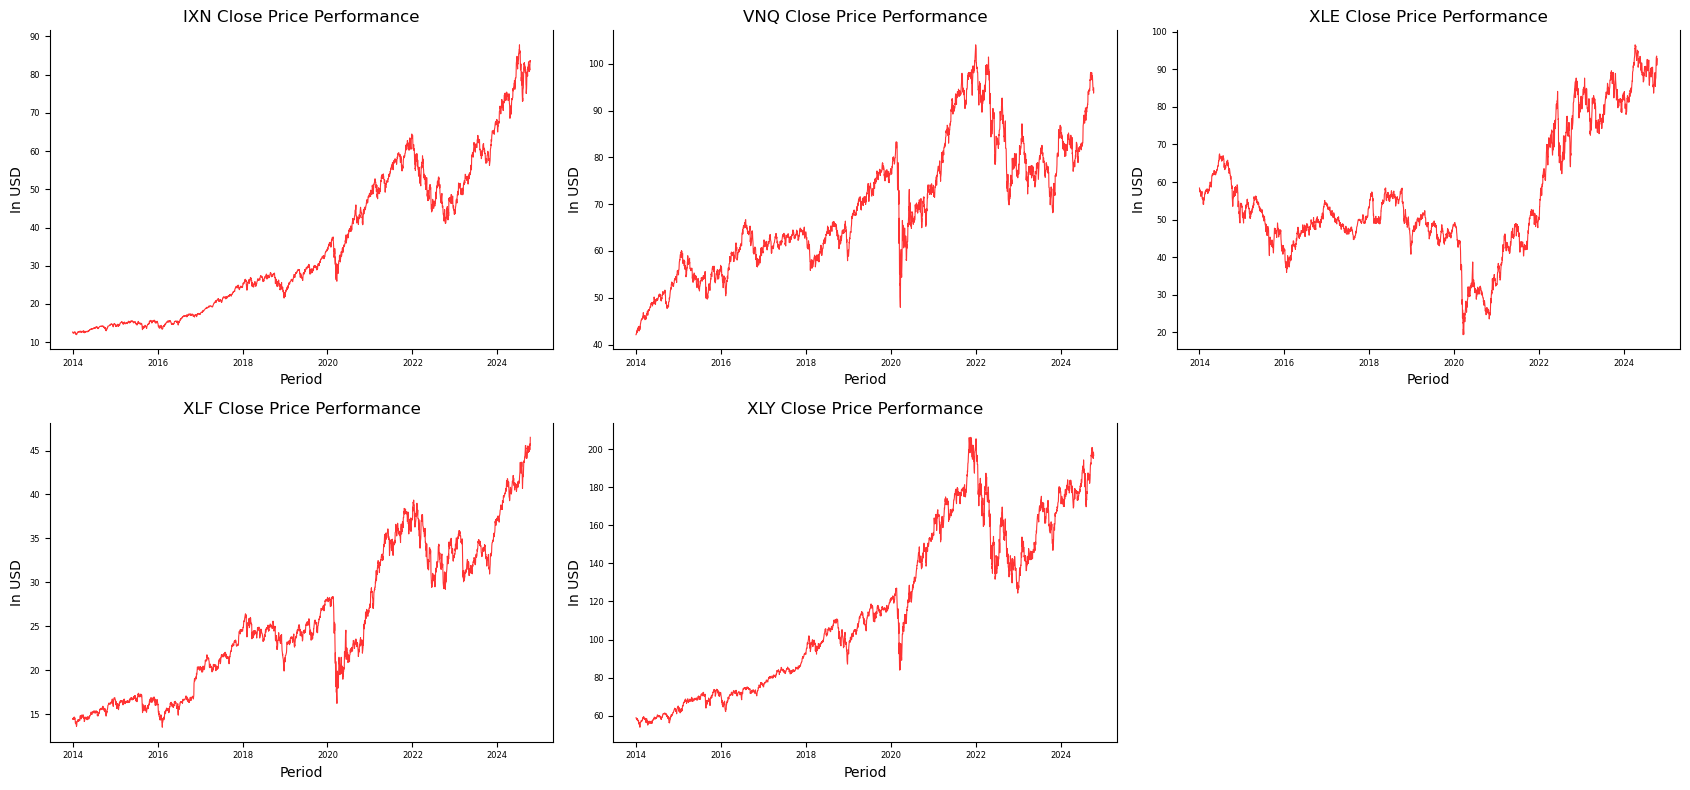

In [20]:
# Visualize the price performance of all ETFs
etfs = ['IXN', 'VNQ', 'XLE', 'XLF', 'XLY']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[17,8])

axs = axs.flatten()

for i, ax in enumerate(axs[:len(etfs)]):
    etf = etf_data[etfs[i]]  # Select the ETF data for the current ETF
    ax.plot(etf_data['Date'], etf, color='red', alpha=0.8, lw=0.8)
    ax.set_title(f"{etfs[i]} Close Price Performance")
    ax.set_xlabel("Period")
    ax.set_ylabel("In USD")
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

# Remove any empty subplots
for i in range(len(etfs), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [33]:
etf_data.columns

Index(['Date', 'IXN', 'VNQ', 'XLE', 'XLF', 'XLY', 'Sentiment Text', 'GDPC1',
       'CPIAUCSL', 'UNRATE', 'PAYEMS', 'RRSFS', 'GFDEBTN', 'VIXCLS', 'DFF',
       'SPY'],
      dtype='object')

In [22]:
# Setting sample to monthly data
monthly_etf_data = etf_data.set_index('Date', inplace=True)

sample_method = {
    'IXN':'mean' , 
    'VNQ':'mean', 
    'XLE':'mean', 
    'XLF':'mean', 
    'XLY':'mean', 
    'Sentiment Text':'last', 
    'GDPC1':'last', # GDP rate (using last value because it is reported less frequently basis)
    'CPIAUCSL':'mean', # CPI
    'UNRATE':'mean', # Unemployment rate
    'PAYEMS':'mean', # Payroll data
    'RRSFS':'mean', # Retail sales
    'GFDEBTN':'last', # Gov debt (using last value because it is reported less frequently basis)
    'VIXCLS':'mean', # VIX index
    'DFF':'mean', # Federal funds rate
    'SPY':'mean'} # SPY ETF S&P500 index

monthly_etf_data = etf_data.resample('ME').agg(sample_method)
monthly_etf_data

,IXN,VNQ,XLE,XLF,XLY,Sentiment Text,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,SPY
Date,,,,,,,,,,,,,,,
2014-01-31,12.457348,43.089764,56.785265,14.375264,57.421918,negative,17953.974000,234.743739,6.695652,137375.000000,180039.217391,1.760123e+07,13.923913,0.070000,150.674932
2014-02-28,12.525245,44.983731,56.341033,14.154623,56.994498,negative,18031.286333,235.300950,6.605000,137558.950000,178198.850000,1.761169e+07,18.189500,0.069500,150.439256
2014-03-31,12.756795,45.954099,57.822968,14.696583,58.264329,negative,18108.598667,235.569905,6.700000,137723.190476,180413.047619,1.762215e+07,13.994286,0.060000,154.474162
2014-04-30,12.737350,47.073186,60.651090,14.561654,56.622703,positive,18185.911000,236.048000,6.677273,138001.136364,181883.181818,1.763261e+07,13.858636,0.061364,154.726890
2014-05-31,12.944183,48.584307,62.489093,14.606373,56.922787,positive,18185.911000,236.468000,6.200000,138298.000000,183336.000000,1.763261e+07,13.410000,0.090000,157.149625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,81.671523,82.019629,88.690768,40.899914,179.240408,positive,22924.863000,313.225000,4.000000,158430.000000,224857.000000,3.483163e+07,12.920000,5.330000,538.035287
2024-07-31,83.266957,86.388983,90.604804,42.437828,187.514398,positive,22924.863000,313.070087,4.108696,158551.869565,224454.652174,3.483163e+07,12.610435,5.330000,550.305972
2024-08-31,79.167727,91.346167,88.788127,43.214182,180.273941,positive,22924.863000,313.534000,4.300000,158637.000000,226581.000000,3.483163e+07,16.360000,5.330000,544.880518


### Part 1: Time Series Decomposition

In [26]:
# Time series decomposition of original series
def decomposets (data, period):
    decompose = STL(data, period = period).fit()
    
    # Plotting the decomposition results 
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18, 7), sharex=True)
    # Plot original series
    decompose.observed.plot(ax=axs[0], c='red')
    axs[0].set_title('Original series', fontsize=12)
    
    # Plot trend series
    decompose.trend.plot(ax=axs[1], c='red')
    axs[1].set_title('Trend', fontsize=12)
    
    # Plot seasonal series
    decompose.seasonal.plot(ax=axs[2], c='red')
    axs[2].set_title('Seasonal', fontsize=12)
    
    # Plot residuals series
    decompose.resid.plot(ax=axs[3], c='red')
    axs[3].set_title('Residuals', fontsize=12)
    
    plt.suptitle('Time series decomposition of original series', fontsize=14)
    plt.tight_layout()

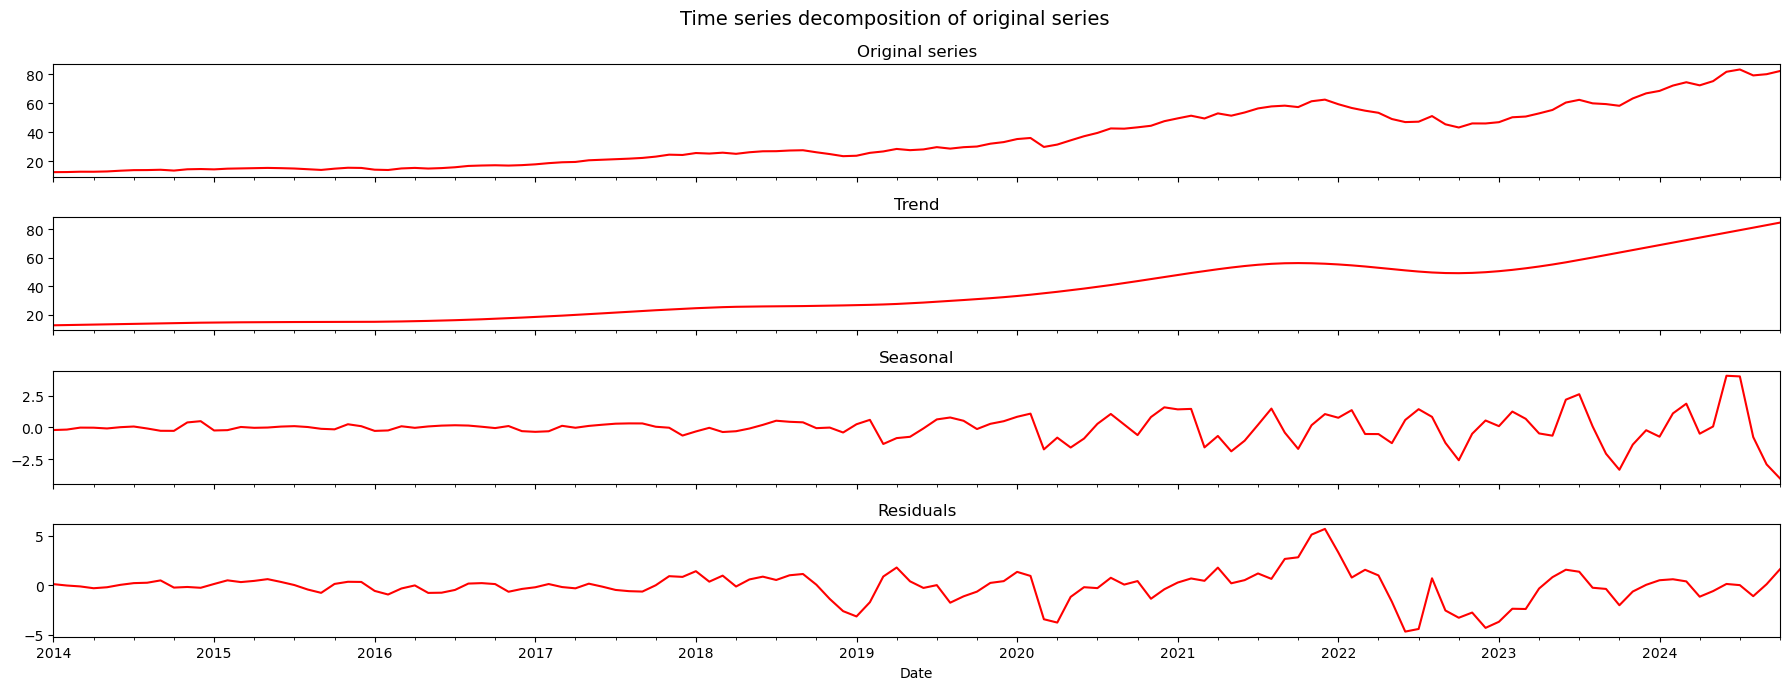

In [28]:
# IXN 
ixn_decompose = decomposets(monthly_etf_data['IXN'], 12) # period is set to 365 because daily data
ixn_decompose

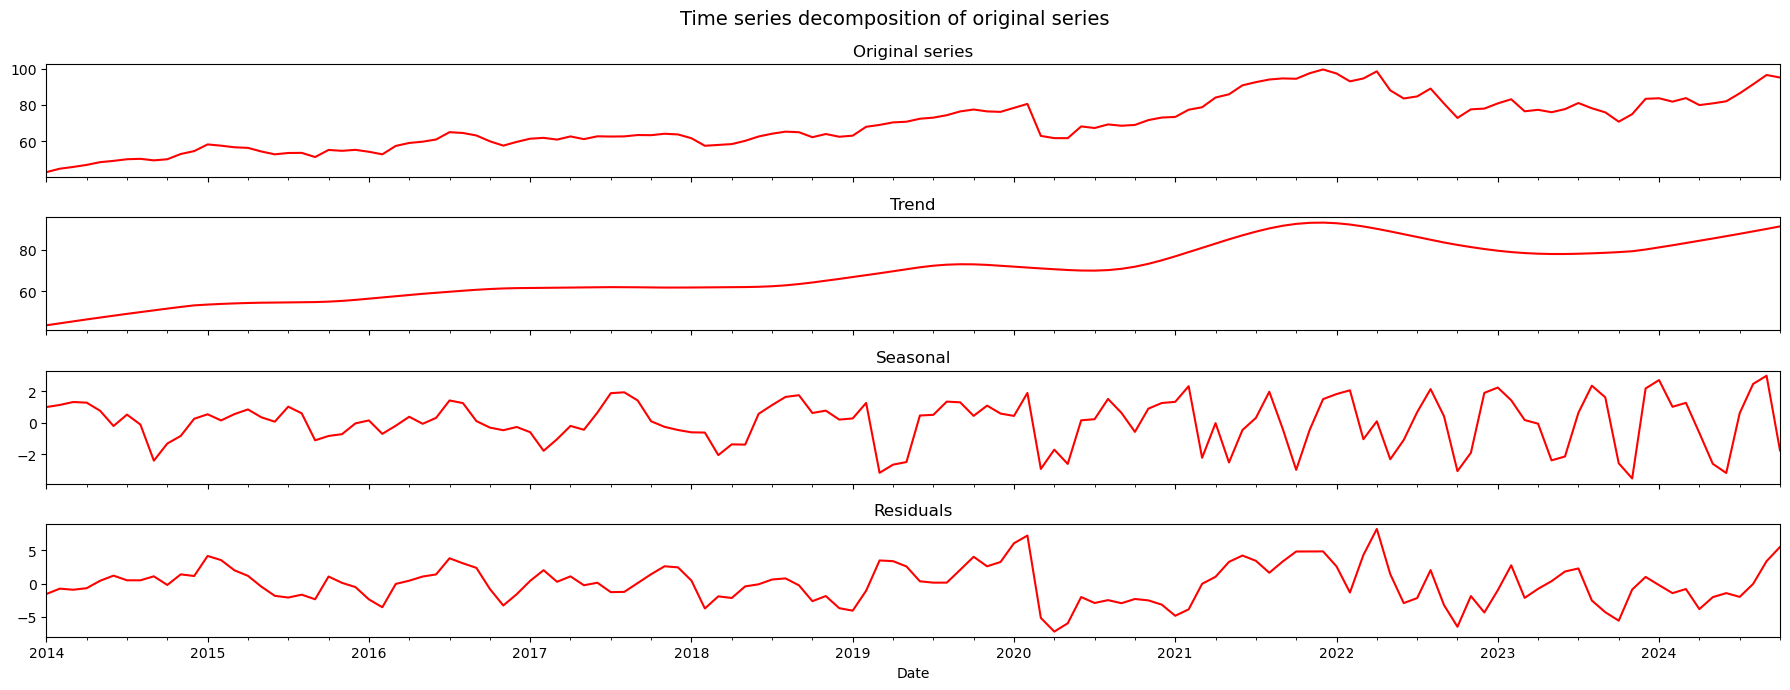

In [30]:
# VNQ
vnq_decompose = decomposets(monthly_etf_data['VNQ'], 12) # period is set to 12 because monthly data
vnq_decompose

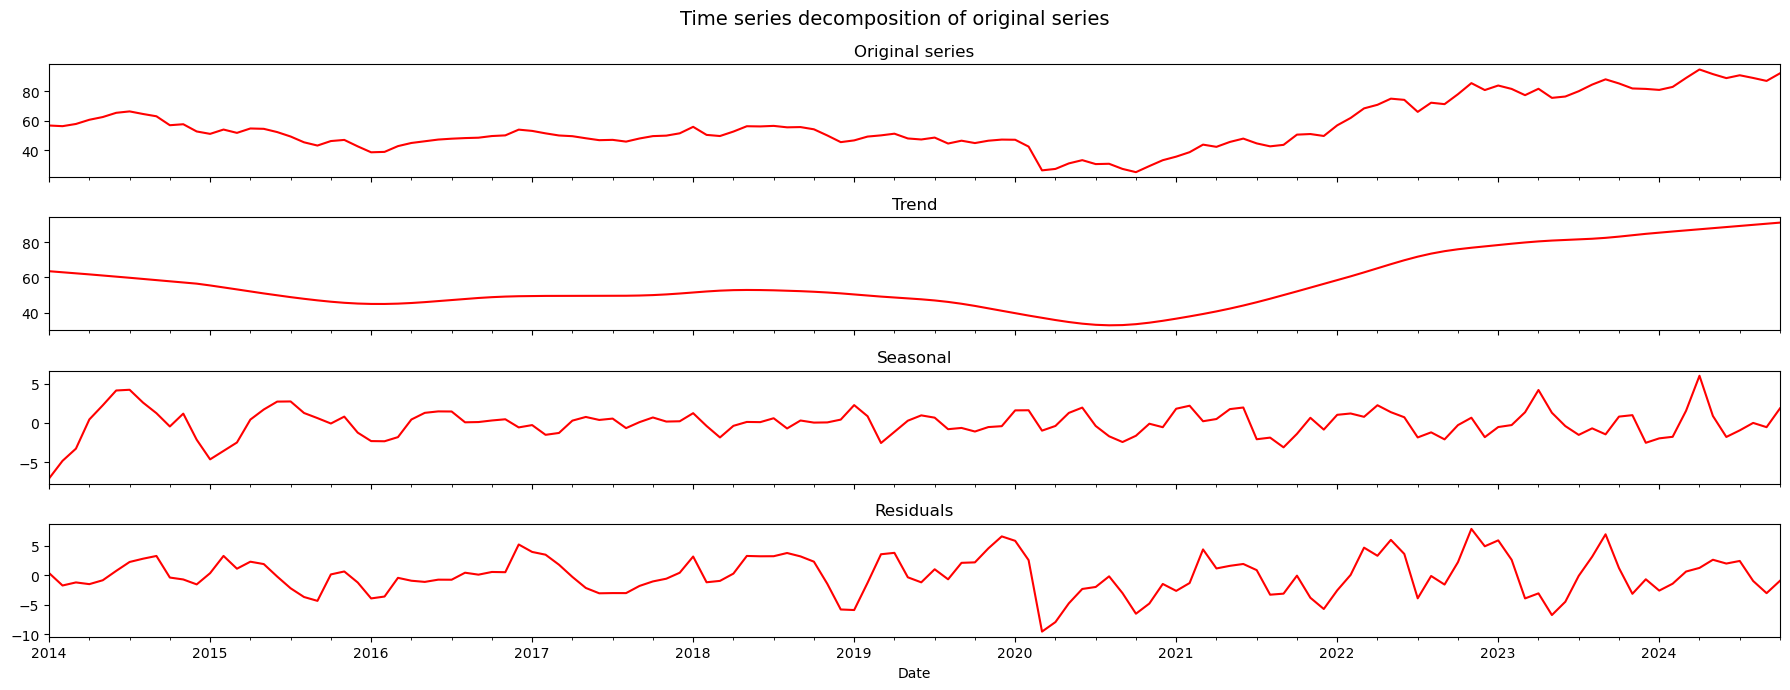

In [32]:
# XLE
xle_decompose = decomposets(monthly_etf_data['XLE'], 12) # period is set to 12 because monthly data
xle_decompose

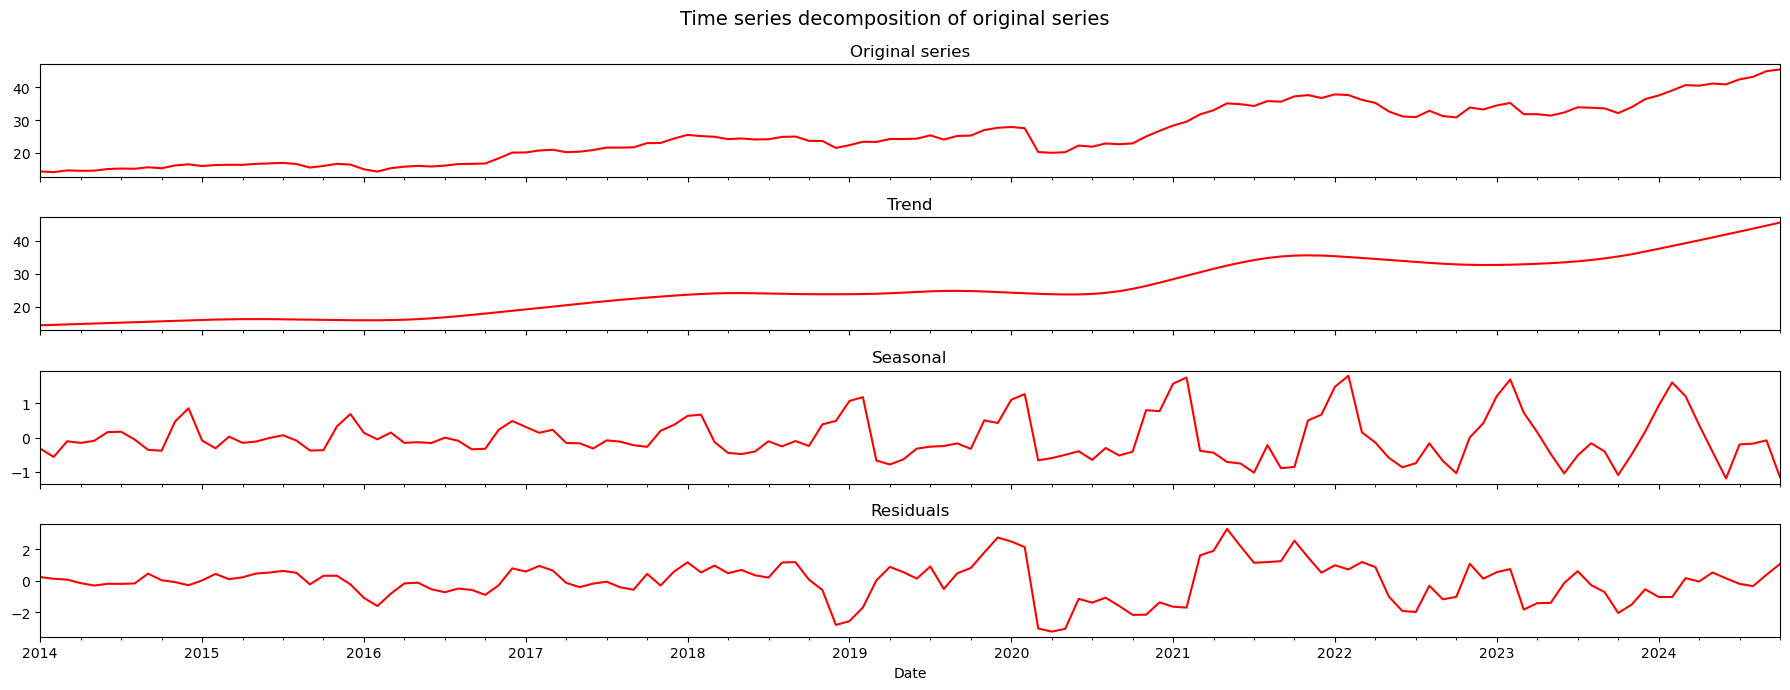

In [34]:
# XLF
xlf_decompose = decomposets(monthly_etf_data['XLF'], 12) # period is set to 12 because monthly data
xlf_decompose

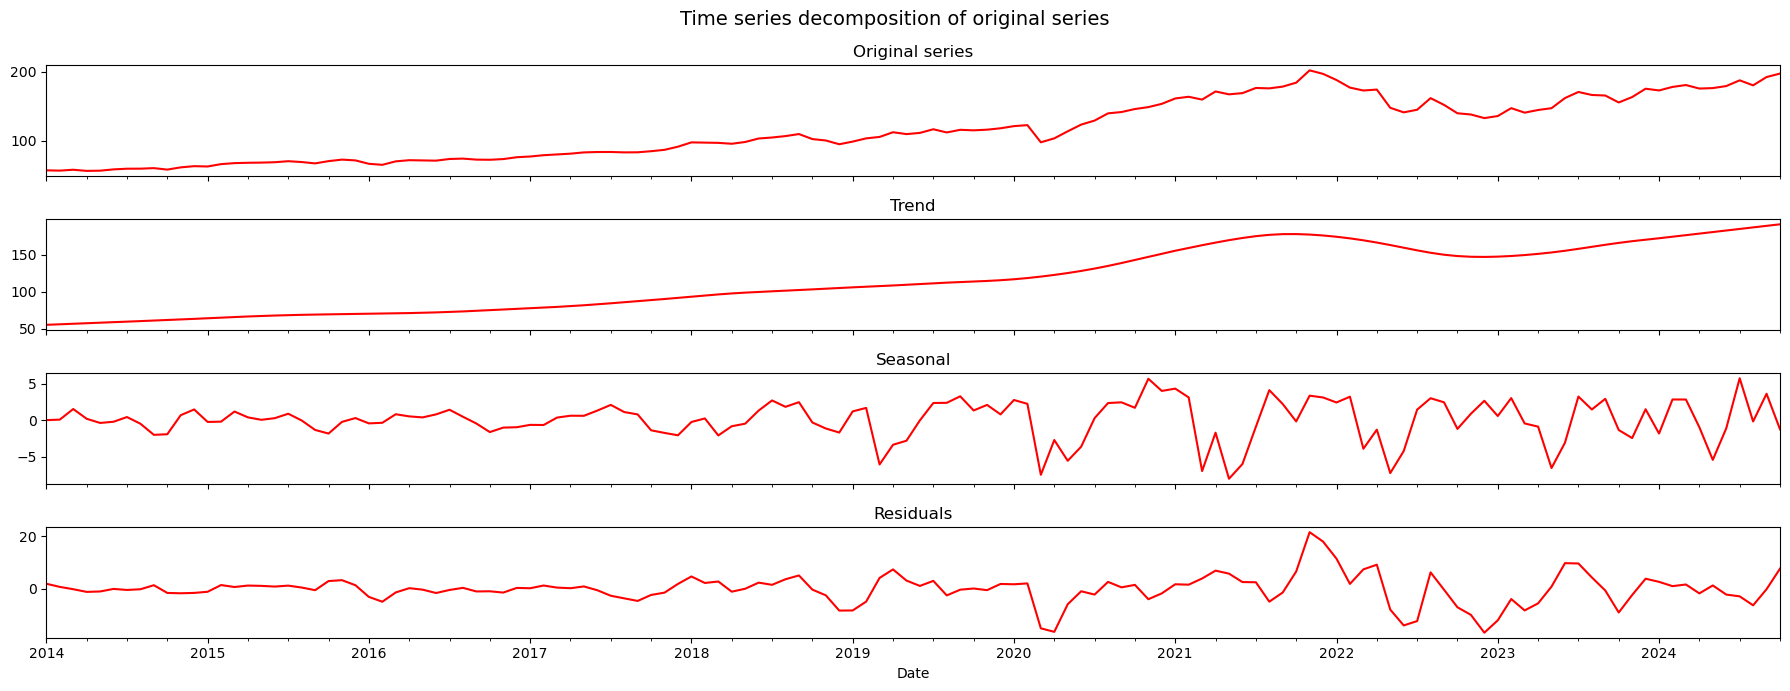

In [36]:
# XLY
xly_decompose = decomposets(monthly_etf_data['XLY'], 12) # period is set to 12 because monthly data
xly_decompose

### Part 2: Exogeneous Variables

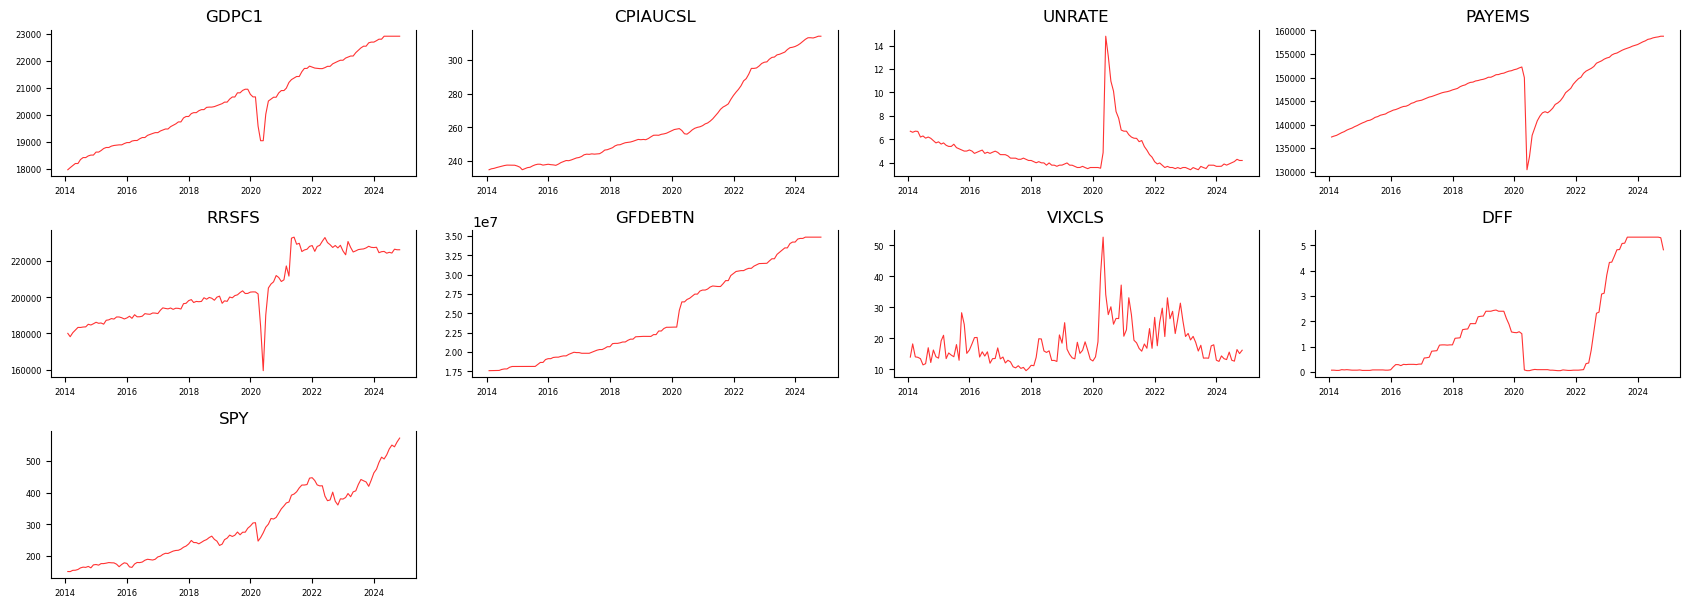

In [38]:
# Visualize pattern for exogeneous variables 
exo_var = ['GDPC1', 'CPIAUCSL', 'UNRATE','PAYEMS', 'RRSFS', 'GFDEBTN', 'VIXCLS', 'DFF','SPY']

fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (17,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(exo_var):
        data = monthly_etf_data[exo_var[i]]
        ax.plot(monthly_etf_data.index,
                data, color = 'red', 
                lw = 0.8, alpha = 0.8)
        ax.set_title(f"{exo_var[i]}")
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)

# Remove any empty subplots
for i in range(len(exo_var), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [40]:
# Defining our target data (y-variable)
target = monthly_etf_data[etfs]
target.head()

,IXN,VNQ,XLE,XLF,XLY
Date,,,,,
2014-01-31,12.457348,43.089764,56.785265,14.375264,57.421918
2014-02-28,12.525245,44.983731,56.341033,14.154623,56.994498
2014-03-31,12.756795,45.954099,57.822968,14.696583,58.264329
2014-04-30,12.737350,47.073186,60.651090,14.561654,56.622703
2014-05-31,12.944183,48.584307,62.489093,14.606373,56.922787


In [42]:
# Defining our independent variables (x)
exog = monthly_etf_data[exo_var]
exog.head()

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,SPY
Date,,,,,,,,,
2014-01-31,17953.974000,234.743739,6.695652,137375.000000,180039.217391,1.760123e+07,13.923913,0.070000,150.674932
2014-02-28,18031.286333,235.300950,6.605000,137558.950000,178198.850000,1.761169e+07,18.189500,0.069500,150.439256
2014-03-31,18108.598667,235.569905,6.700000,137723.190476,180413.047619,1.762215e+07,13.994286,0.060000,154.474162
2014-04-30,18185.911000,236.048000,6.677273,138001.136364,181883.181818,1.763261e+07,13.858636,0.061364,154.726890
2014-05-31,18185.911000,236.468000,6.200000,138298.000000,183336.000000,1.763261e+07,13.410000,0.090000,157.149625


### Part 3: Stationarity Test

In [44]:
# Test for stationarity for target variables
for col in target.columns:
    print(f'Test stationarity for original series of {col} price')
    adf_test = adfuller(target[col]) 
    kpss_test = kpss(target[col])
    print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}") # if p-value < 0.05, data is stationary
    print(f"KPSS Statistic: {kpss_test[0]}, p-value: {kpss_test[1]}\n")

Test stationarity for original series of IXN price
ADF Statistic: 1.355628176447061, p-value: 0.9969029431839327
KPSS Statistic: 1.822278933981878, p-value: 0.01

Test stationarity for original series of VNQ price
ADF Statistic: -1.391906452827883, p-value: 0.5861500572687743
KPSS Statistic: 1.6606649943306764, p-value: 0.01

Test stationarity for original series of XLE price
ADF Statistic: -0.5349886092860004, p-value: 0.8850059762582498
KPSS Statistic: 0.7682375162599435, p-value: 0.01

Test stationarity for original series of XLF price
ADF Statistic: 0.03132947895133839, p-value: 0.9610475866140471
KPSS Statistic: 1.7916730308889965, p-value: 0.01

Test stationarity for original series of XLY price
ADF Statistic: -0.2963397338811606, p-value: 0.9260211380127702
KPSS Statistic: 1.8284036678739417, p-value: 0.01



/var/folders/t4/c0tgfh4n2b95nwh171v0dkk40000gn/T/ipykernel_1908/137119884.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(target[col])
/var/folders/t4/c0tgfh4n2b95nwh171v0dkk40000gn/T/ipykernel_1908/137119884.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(target[col])
/var/folders/t4/c0tgfh4n2b95nwh171v0dkk40000gn/T/ipykernel_1908/137119884.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(target[col])
/var/folders/t4/c0tgfh4n2b95nwh171v0dkk40000gn/T/ipykernel_1908/137119884.py:5: InterpolationWarning: The test statistic is outside of the range of p-values availa

> Since data is not stationary, we proceed to next step which is differencing

### Part 4: Data Differencing 

In [46]:
# Find the optimal number of seasonal differencing

for col in target.columns:
    n_diffs_adf = pm.arima.ndiffs(target[col], test='adf') 
    n_diffs_kpss = pm.arima.ndiffs(target[col], test='kpss') 
    print(f"Optimal number of seasonal differencing for {col} price: {n_diffs_adf} based on ADF test and {n_diffs_kpss} based on KPSS test\n")

Optimal number of seasonal differencing for IXN price: 1 based on ADF test and 1 based on KPSS test

Optimal number of seasonal differencing for VNQ price: 1 based on ADF test and 1 based on KPSS test

Optimal number of seasonal differencing for XLE price: 1 based on ADF test and 1 based on KPSS test

Optimal number of seasonal differencing for XLF price: 1 based on ADF test and 1 based on KPSS test

Optimal number of seasonal differencing for XLY price: 1 based on ADF test and 1 based on KPSS test



In [48]:
# Apply for first seasonal differencing 

diff_1_df = target.diff(periods=12).dropna() # yearly seasonality
diff_1_df.columns = target.columns

In [50]:
diff_1_df

,IXN,VNQ,XLE,XLF,XLY
Date,,,,,
2015-01-31,1.917640,15.237266,-5.627927,1.648465,5.563890
2015-02-28,2.333689,12.649738,-2.275934,2.160078,9.398108
2015-03-31,2.251204,10.796774,-5.994062,1.709348,9.572395
2015-04-30,2.389462,9.348350,-5.859946,1.831032,11.726904
2015-05-31,2.433304,5.852759,-7.939348,2.075965,11.664377
...,...,...,...,...,...
2024-06-30,21.214208,4.310992,12.395959,8.571266,17.336181
2024-07-31,20.936294,5.323023,10.729198,8.517334,16.824633
2024-08-31,19.259937,13.163862,4.467975,9.423233,13.916211


In [52]:
# Test for stationarity on first order seasonal differenced data
# Interpolation warning may occured from KPSS test due to p-value is too high (non-stationarity) or too low (stationarity)

for col in diff_1_df.columns:
    print(f'Test stationarity for first seasonal order differencing series of {col} stock price')
    # Perform ADF test 
    adf_test_diff_1 = adfuller(diff_1_df[col])
    print(f"ADF Statistic: {adf_test_diff_1[0]}, p-value: {adf_test_diff_1[1]}")

    # Perform KPSS test
    with warnings.catch_warnings(record=True) as w:
        kpss_test_diff_1 = kpss(diff_1_df[col], regression='ct') # regression with constant and trend
        print(f"KPSS Statistic: {kpss_test_diff_1[0]}, p-value: {kpss_test_diff_1[1]}\n")

Test stationarity for first seasonal order differencing series of IXN stock price
ADF Statistic: -1.784328148295399, p-value: 0.388269620957691
KPSS Statistic: 0.06802539511335076, p-value: 0.1

Test stationarity for first seasonal order differencing series of VNQ stock price
ADF Statistic: -2.8795342047462977, p-value: 0.047780176400514095
KPSS Statistic: 0.05512849731210542, p-value: 0.1

Test stationarity for first seasonal order differencing series of XLE stock price
ADF Statistic: -1.8343082711920253, p-value: 0.3635664715970005
KPSS Statistic: 0.10286192350889173, p-value: 0.1

Test stationarity for first seasonal order differencing series of XLF stock price
ADF Statistic: -2.220137515556934, p-value: 0.19901804663607814
KPSS Statistic: 0.05126358298727026, p-value: 0.1

Test stationarity for first seasonal order differencing series of XLY stock price
ADF Statistic: -2.8753854624611224, p-value: 0.04828611952104886
KPSS Statistic: 0.0753581236614673, p-value: 0.1



In [54]:
# Apply for first second differencing 

diff_2_df = diff_1_df.diff().dropna()
diff_2_df.columns = target.columns
diff_2_df

,IXN,VNQ,XLE,XLF,XLY
Date,,,,,
2015-02-28,0.416049,-2.587528,3.351993,0.511613,3.834218
2015-03-31,-0.082485,-1.852964,-3.718128,-0.450730,0.174287
2015-04-30,0.138258,-1.448425,0.134116,0.121684,2.154508
2015-05-31,0.043842,-3.495591,-2.079402,0.244933,-0.062527
2015-06-30,-0.675675,-2.263539,-5.026323,-0.352425,-1.301812
...,...,...,...,...,...
2024-06-30,1.350350,-0.551123,-3.589224,-1.206723,-11.700047
2024-07-31,-0.277914,1.012031,-1.666761,-0.053932,-0.511548
2024-08-31,-1.676357,7.840840,-6.261223,0.905899,-2.908421


In [56]:
# Test for stationarity on second order differenced data

for col in diff_2_df.columns:
    print(f'Test stationarity for second order differencing series of {col} stock price')
    # Perform ADF test 
    adf_test_diff_2 = adfuller(diff_2_df[col])
    print(f"ADF Statistic: {adf_test_diff_2[0]}, p-value: {adf_test_diff_2[1]}")

    # Perform KPSS test
    with warnings.catch_warnings(record=True) as w:
        kpss_test_diff_2 = kpss(diff_2_df[col], regression='ct') # regression with constant and trend
        print(f"KPSS Statistic: {kpss_test_diff_2[0]}, p-value: {kpss_test_diff_2[1]}\n")

Test stationarity for second order differencing series of IXN stock price
ADF Statistic: -4.480028227828664, p-value: 0.00021364140455683062
KPSS Statistic: 0.07201424597404783, p-value: 0.1

Test stationarity for second order differencing series of VNQ stock price
ADF Statistic: -5.318731427146117, p-value: 5.007074816972565e-06
KPSS Statistic: 0.07754712637328383, p-value: 0.1

Test stationarity for second order differencing series of XLE stock price
ADF Statistic: -4.086771251802028, p-value: 0.0010184542688151227
KPSS Statistic: 0.04793571918493104, p-value: 0.1

Test stationarity for second order differencing series of XLF stock price
ADF Statistic: -6.150107433800811, p-value: 7.598563551033367e-08
KPSS Statistic: 0.057270714397937815, p-value: 0.1

Test stationarity for second order differencing series of XLY stock price
ADF Statistic: -4.959428690649686, p-value: 2.6683826180402762e-05
KPSS Statistic: 0.054064052739038325, p-value: 0.1



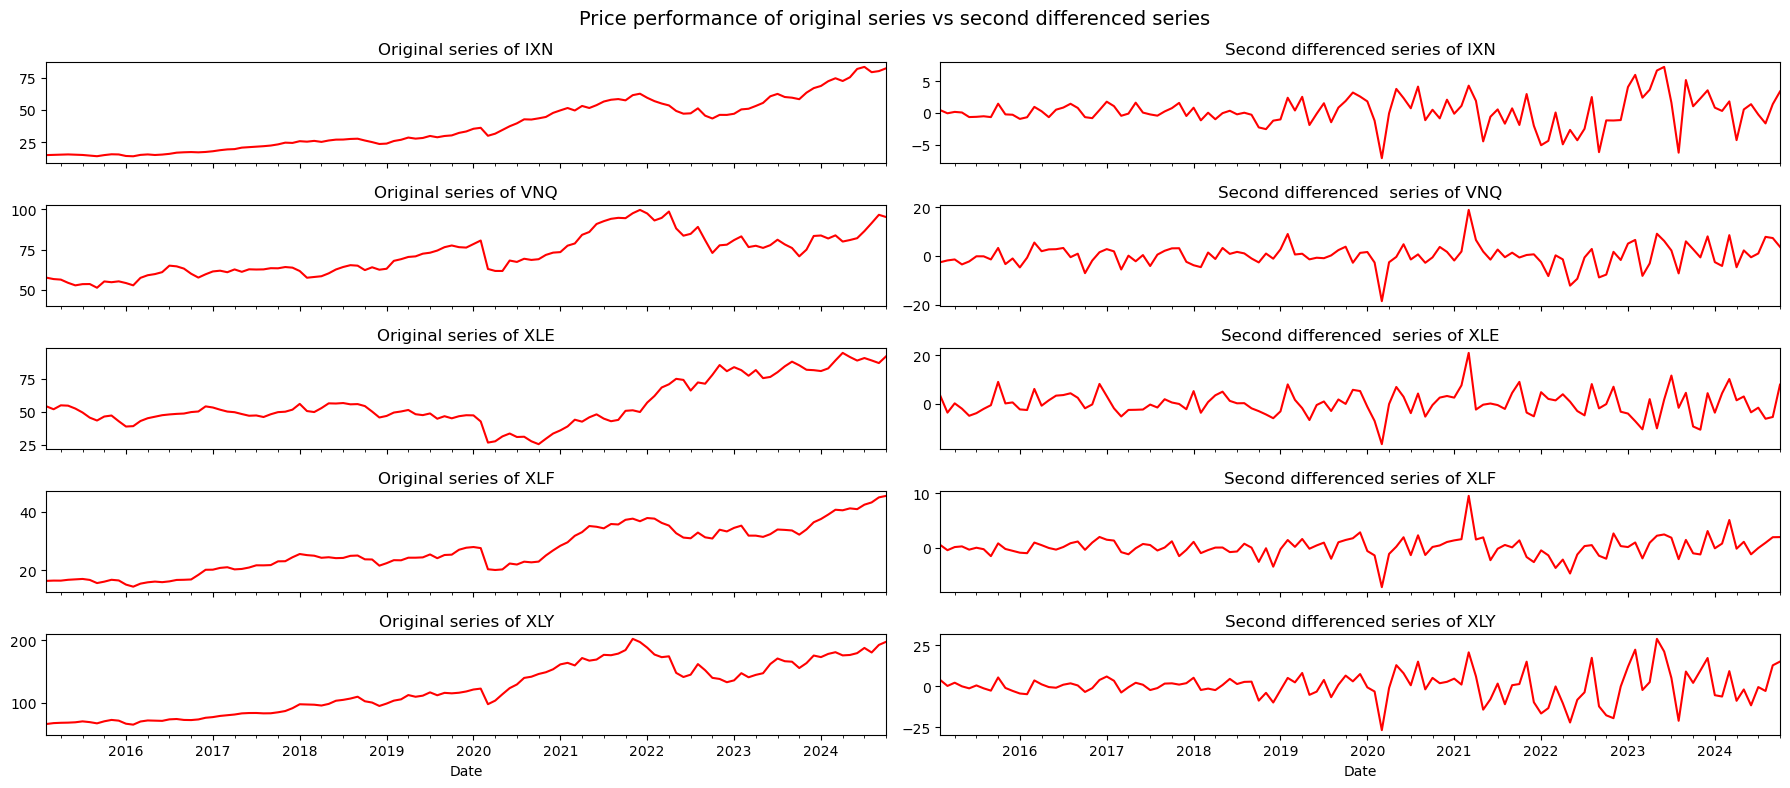

In [58]:
# Plot original vs differenced series
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 8), sharex=True)

# For original series
monthly_etf_data['IXN'].plot(ax=axs[0, 0], c='red')
axs[0, 0].set_title('Original series of IXN', fontsize=12)
monthly_etf_data['VNQ'].plot(ax=axs[1, 0], c='red')
axs[1, 0].set_title('Original series of VNQ', fontsize=12)
monthly_etf_data['XLE'].plot(ax=axs[2, 0], c='red')
axs[2, 0].set_title('Original series of XLE', fontsize=12)
monthly_etf_data['XLF'].plot(ax=axs[3, 0], c='red')
axs[3, 0].set_title('Original series of XLF', fontsize=12)
monthly_etf_data['XLY'].plot(ax=axs[4, 0], c='red')
axs[4, 0].set_title('Original series of XLY', fontsize=12)

# For second differenced series
diff_2_df['IXN'].plot(ax=axs[0, 1], c='red')
axs[0, 1].set_title('Second differenced series of IXN', fontsize=12)
diff_2_df['VNQ'].plot(ax=axs[1, 1], c='red')
axs[1, 1].set_title('Second differenced  series of VNQ', fontsize=12)
diff_2_df['XLE'].plot(ax=axs[2, 1], c='red')
axs[2, 1].set_title('Second differenced  series of XLE', fontsize=12)
diff_2_df['XLF'].plot(ax=axs[3, 1], c='red')
axs[3, 1].set_title('Second differenced series of XLF', fontsize=12)
diff_2_df['XLY'].plot(ax=axs[4, 1], c='red')
axs[4, 1].set_title('Second differenced series of XLY', fontsize=12)


plt.suptitle('Price performance of original series vs second differenced series', fontsize=14)
plt.tight_layout()

### Part 5: Autocorrelation Function

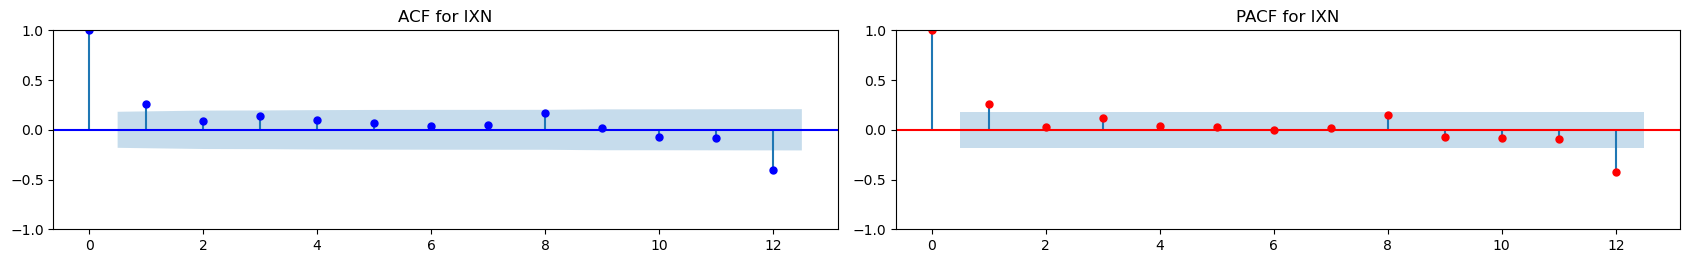

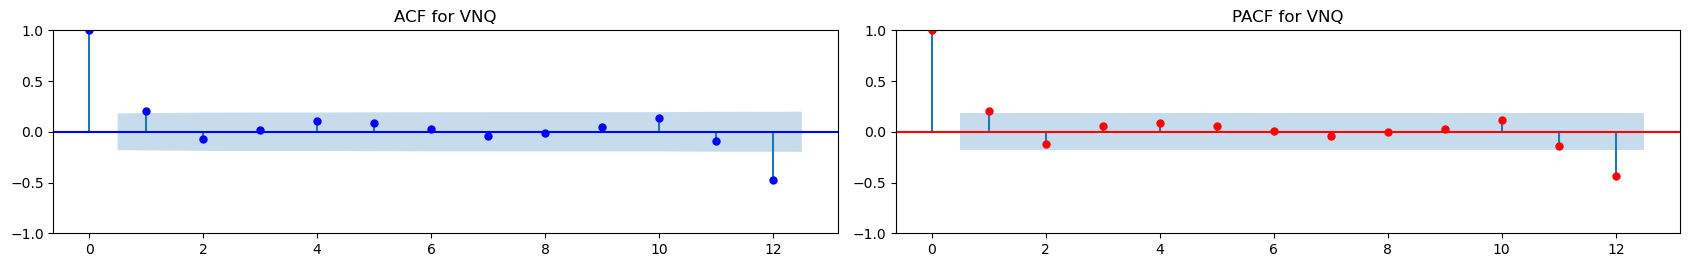

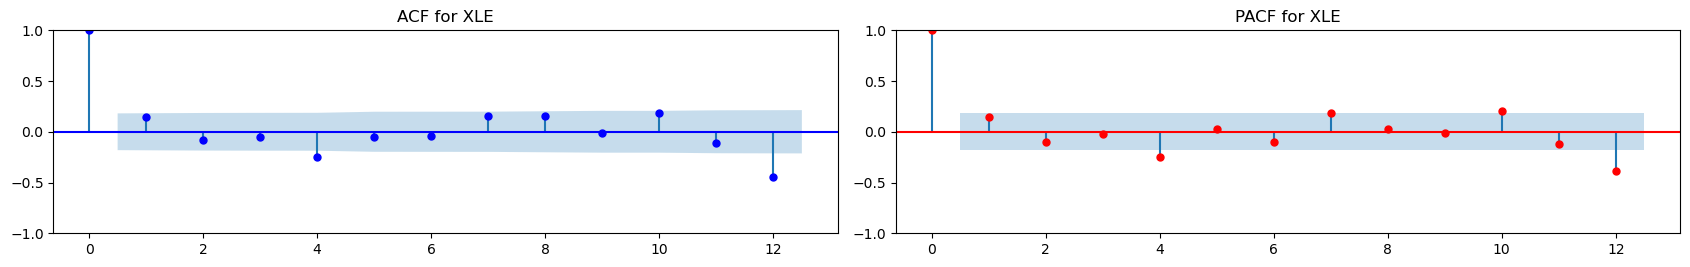

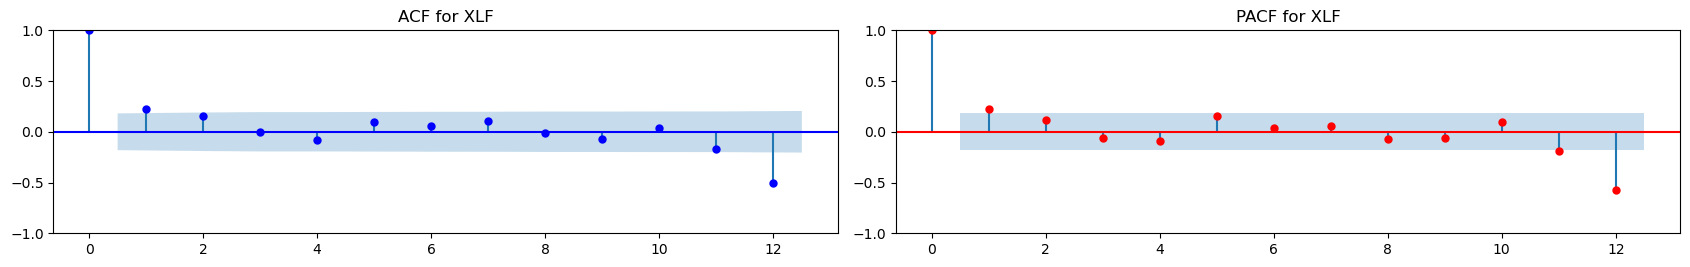

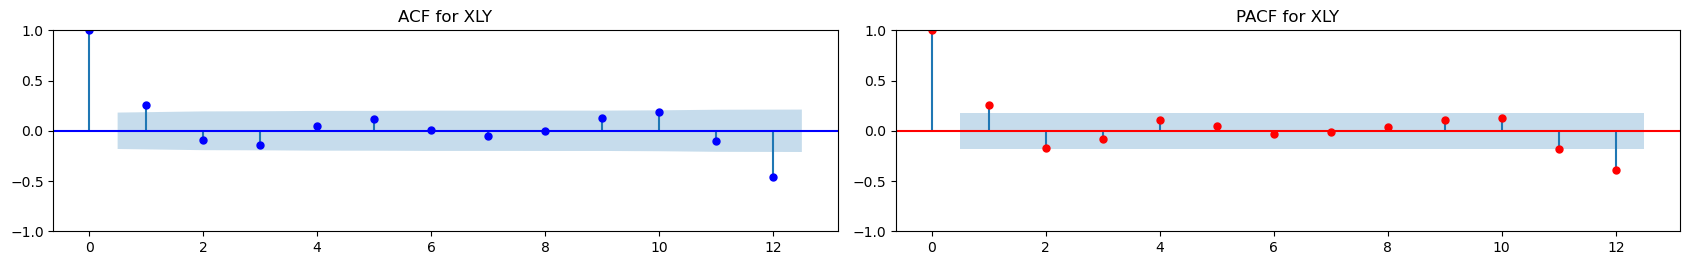

In [60]:
for i, col in enumerate(diff_2_df.columns):
    plt.figure(figsize = (17, 12))
    n_rows = 5
    n_cols = 2
    
    # For ACF plot
    plt.subplot(n_rows, n_cols, 2*i+1)
    plot_acf(diff_2_df[col].dropna(), lags = 12, color = 'blue', ax = plt.gca())
    plt.title(f"ACF for {col}")

    # For PACF plot
    plt.subplot(n_rows, n_cols, 2*i+2)
    plot_pacf(diff_2_df[col].dropna(), lags = 12, color = 'red', ax = plt.gca())
    plt.title(f"PACF for {col}")

    plt.tight_layout()
    plt.show()

### Part 6: SARIMAX Model Forecasting

In [232]:
from tqdm import tqdm

In [62]:
# Check lengths of endog and exog variables
print(f"Length of endog: {len(diff_2_df)}")
print(f"Length of exog: {len(exog)}")

Length of endog: 117
Length of exog: 130


In [64]:
# Align the exog variables dataframe into endogeneous variables dataframe shape
exog_trim_aligned = exog.loc[diff_2_df.index.min():diff_2_df.index.max()]
exog_trim_aligned.shape[0] == diff_2_df.shape[0]

True

In [66]:
diff_2_df

,IXN,VNQ,XLE,XLF,XLY
Date,,,,,
2015-02-28,0.416049,-2.587528,3.351993,0.511613,3.834218
2015-03-31,-0.082485,-1.852964,-3.718128,-0.450730,0.174287
2015-04-30,0.138258,-1.448425,0.134116,0.121684,2.154508
2015-05-31,0.043842,-3.495591,-2.079402,0.244933,-0.062527
2015-06-30,-0.675675,-2.263539,-5.026323,-0.352425,-1.301812
...,...,...,...,...,...
2024-06-30,1.350350,-0.551123,-3.589224,-1.206723,-11.700047
2024-07-31,-0.277914,1.012031,-1.666761,-0.053932,-0.511548
2024-08-31,-1.676357,7.840840,-6.261223,0.905899,-2.908421


In [68]:
exog_trim_aligned

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,SPY
Date,,,,,,,,,
2015-02-28,18666.621000,234.747000,5.700000,140562.000000,185785.000000,1.815206e+07,20.970000,0.060000,175.655935
2015-03-31,18743.702333,235.370818,5.495455,140835.272727,185130.545455,1.815202e+07,13.428636,0.060000,175.748815
2015-04-30,18782.243000,235.987182,5.400000,140937.590909,187274.727273,1.815200e+07,15.256364,0.060909,177.126312
2015-05-31,18782.243000,236.222000,5.400000,141202.000000,187521.000000,1.815200e+07,14.550000,0.080000,179.034906
2015-06-30,18832.359667,237.030818,5.586364,141546.090909,188218.136364,1.815108e+07,14.039545,0.080000,178.252999
...,...,...,...,...,...,...,...,...,...
2024-06-30,22924.863000,313.225000,4.000000,158430.000000,224857.000000,3.483163e+07,12.920000,5.330000,538.035287
2024-07-31,22924.863000,313.070087,4.108696,158551.869565,224454.652174,3.483163e+07,12.610435,5.330000,550.305972
2024-08-31,22924.863000,313.534000,4.300000,158637.000000,226581.000000,3.483163e+07,16.360000,5.330000,544.880518


#### ETF 1: IXN

In [72]:
# Setting the training dataset
prop = int(len(diff_2_df) * 0.75)
exog_train_aligned = exog_trim_aligned.iloc[ : prop] # using 75% of data as training set (aligned to the endog)

In [74]:
# Using seasonal - fit stepwise auto-ARIMA to determine the order of SARIMA
ixn_target_train = diff_2_df.iloc[ : prop]['IXN'] # using 75% of data as training set

ixn_SARIMA_model = auto_arima(ixn_target_train, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #monthly seasonality frequency
                         start_P=0, start_Q=0,
                         max_P = 3, max_Q=3, 
                         seasonal=True, #set to seasonal
                         d=1, 
                         D=1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, exogenous=exog_train_aligned)

ixn_SARIMA_model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=410.139, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=374.136, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=406.567, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=366.801, Time=0.13 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=366.495, Time=0.22 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=378.038, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=359.752, Time=0.34 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=361.543, Time=0.11 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=352.540, Time=0.37 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=354.871, T

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(3, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [78]:
# Store the suggested order and seasonal order
ixn_lowest_aic = [ixn_SARIMA_model.order[0], 
                  ixn_SARIMA_model.order[2], 
                  ixn_SARIMA_model.seasonal_order[0], 
                  ixn_SARIMA_model.seasonal_order[2]]

ixn_lowest_aic

[0, 1, 3, 0]

#### ETF 2: VNQ

In [80]:
# Using seasonal - fit stepwise auto-ARIMA
vnq_target_train = diff_2_df.iloc[ : prop]['VNQ'] # using 75% of data as training set
vnq_SARIMA_model = auto_arima(vnq_target_train, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, start_Q=0,
                         max_P = 3, max_Q=3, 
                         seasonal=True, #set to seasonal
                         d=1, 
                         D=1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, exogenous=exog_train_aligned)

vnq_SARIMA_model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=527.054, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=489.412, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=523.134, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=476.727, Time=0.12 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=477.475, Time=0.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=484.785, Time=0.07 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=473.398, Time=0.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=487.226, Time=0.06 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=473.196, Time=0.56 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=467.980, Time=2.06 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, T

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(3, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [82]:
# Store the suggested order and seasonal order
vnq_lowest_aic = [vnq_SARIMA_model.order[0], 
                  vnq_SARIMA_model.order[2], 
                  vnq_SARIMA_model.seasonal_order[0], 
                  vnq_SARIMA_model.seasonal_order[2]]

vnq_lowest_aic

[2, 0, 3, 1]

#### ETF 3: XLE

In [84]:
# Using seasonal - fit stepwise auto-ARIMA
xle_target_train = diff_2_df.iloc[ : prop]['XLE'] # using 75% of data as training set
xle_SARIMA_model = auto_arima(xle_target_train, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, start_Q=0,
                         max_P = 3, max_Q=3, 
                         seasonal=True, #set to seasonal
                         d=1, 
                         D=1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, exogenous=exog_train_aligned)

xle_SARIMA_model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=558.148, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=511.799, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=555.918, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=498.555, Time=0.18 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=497.345, Time=0.29 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=508.033, Time=0.17 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=491.753, Time=0.46 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=494.688, Time=0.15 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=490.243, Time=0.48 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=493.653, T

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(3, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [86]:
# Store the suggested order and seasonal order
xle_lowest_aic = [xle_SARIMA_model.order[0], 
                  xle_SARIMA_model.order[2], 
                  xle_SARIMA_model.seasonal_order[0], 
                  xle_SARIMA_model.seasonal_order[2]]

xle_lowest_aic

[0, 1, 3, 0]

#### ETF 4: XLF

In [88]:
# Using seasonal - fit stepwise auto-ARIMA
xlf_target_train = diff_2_df.iloc[ : prop]['XLF'] # using 75% of data as training set
xlf_SARIMA_model = auto_arima(xlf_target_train, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, start_Q=0,
                         max_P = 3, max_Q=3, 
                         seasonal=True, #set to seasonal
                         d=1, 
                         D=1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, exogenous=exog_train_aligned)

xlf_SARIMA_model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=416.117, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=357.481, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=402.535, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=341.577, Time=0.13 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=339.221, Time=0.32 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=360.658, Time=0.18 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=339.127, Time=0.38 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=341.741, Time=0.11 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=338.999, Time=0.37 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=342.187, T

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(3, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [90]:
# Store the suggested order and seasonal order
xlf_lowest_aic = [xlf_SARIMA_model.order[0], 
                  xlf_SARIMA_model.order[2], 
                  xlf_SARIMA_model.seasonal_order[0], 
                  xlf_SARIMA_model.seasonal_order[2]]

xlf_lowest_aic

[3, 0, 3, 0]

#### ETF 5: XLY

In [92]:
# Using seasonal - fit stepwise auto-ARIMA
xly_target_train = diff_2_df.iloc[ : prop]['XLY'] # using 75% of data as training set
xly_SARIMA_model = auto_arima(xly_target_train, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, start_Q=0,
                         max_P = 3, max_Q=3, 
                         seasonal=True, #set to seasonal
                         d=1, 
                         D=1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, exogenous=exog_train_aligned)

xly_SARIMA_model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=599.601, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=562.352, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=595.264, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=554.095, Time=0.17 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=554.880, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=563.343, Time=0.10 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=549.519, Time=0.15 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=557.724, Time=0.07 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=549.283, Time=0.38 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(3, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [94]:
# Store the suggested order and seasonal order
xly_lowest_aic = [xly_SARIMA_model.order[0], 
                  xly_SARIMA_model.order[2], 
                  xly_SARIMA_model.seasonal_order[0], 
                  xly_SARIMA_model.seasonal_order[2]]

xly_lowest_aic

[3, 0, 3, 0]

### Part 7: Model Testing

In [96]:
etfs

['IXN', 'VNQ', 'XLE', 'XLF', 'XLY']

In [98]:
# Testing the model (Solution 1)
etfs_lowest_aic = {
    'IXN':ixn_lowest_aic, 
    'VNQ':vnq_lowest_aic,
    'XLE':xle_lowest_aic,
    'XLF':xlf_lowest_aic,
    'XLY':xly_lowest_aic}

sarimax_results = {}

for item in etfs:
    target_trainset = diff_2_df.iloc[ : prop][item]
    p_order = etfs_lowest_aic[item][0]
    q_order = etfs_lowest_aic[item][1]
    P_order = etfs_lowest_aic[item][2]
    Q_order = etfs_lowest_aic[item][3]
    d, D, s = 1, 1, 12
    model = SARIMAX(target_trainset, 
                    exog_train_aligned, 
                    order = (p_order, d, q_order), 
                    seasonal_order = (P_order, D, Q_order, s),
                    trend = 'c', # include constant term in the model 
                    simple_differencing=False)
    model_res = model.fit(disp=0)
    
    sarimax_results[item] = model_res
    
    warnings.filterwarnings("default")
    
    print(f"\nSummary of SARIMAX Model Results for {item}")
    print(model_res.summary())


Summary of SARIMAX Model Results for IXN
                                      SARIMAX Results                                      
Dep. Variable:                                 IXN   No. Observations:                   87
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -160.211
Date:                             Sat, 26 Oct 2024   AIC                            350.422
Time:                                     15:13:45   BIC                            384.983
Sample:                                 02-28-2015   HQIC                           364.209
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0640      0.345      0.186      0.853      -0.6

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Summary of SARIMAX Model Results for VNQ
                                      SARIMAX Results                                       
Dep. Variable:                                  VNQ   No. Observations:                   87
Model:             SARIMAX(2, 1, 0)x(3, 1, [1], 12)   Log Likelihood                -227.785
Date:                              Sat, 26 Oct 2024   AIC                            489.571
Time:                                      15:13:47   BIC                            528.740
Sample:                                  02-28-2015   HQIC                           505.196
                                       - 04-30-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0997      2.570      0.039      0.969  

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Summary of SARIMAX Model Results for XLE
                                      SARIMAX Results                                      
Dep. Variable:                                 XLE   No. Observations:                   87
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -253.289
Date:                             Sat, 26 Oct 2024   AIC                            536.578
Time:                                     15:13:50   BIC                            571.139
Sample:                                 02-28-2015   HQIC                           550.365
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7546      1.765      0.428      0.669      -2.7

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Summary of SARIMAX Model Results for XLF
                                     SARIMAX Results                                      
Dep. Variable:                                XLF   No. Observations:                   87
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -173.153
Date:                            Sat, 26 Oct 2024   AIC                            380.306
Time:                                    15:13:53   BIC                            419.475
Sample:                                02-28-2015   HQIC                           395.931
                                     - 04-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2179      0.715     -0.305      0.760      -1.619      

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Part 8: Residuals Diagnostics

#### Step 1: Using Visual Plot

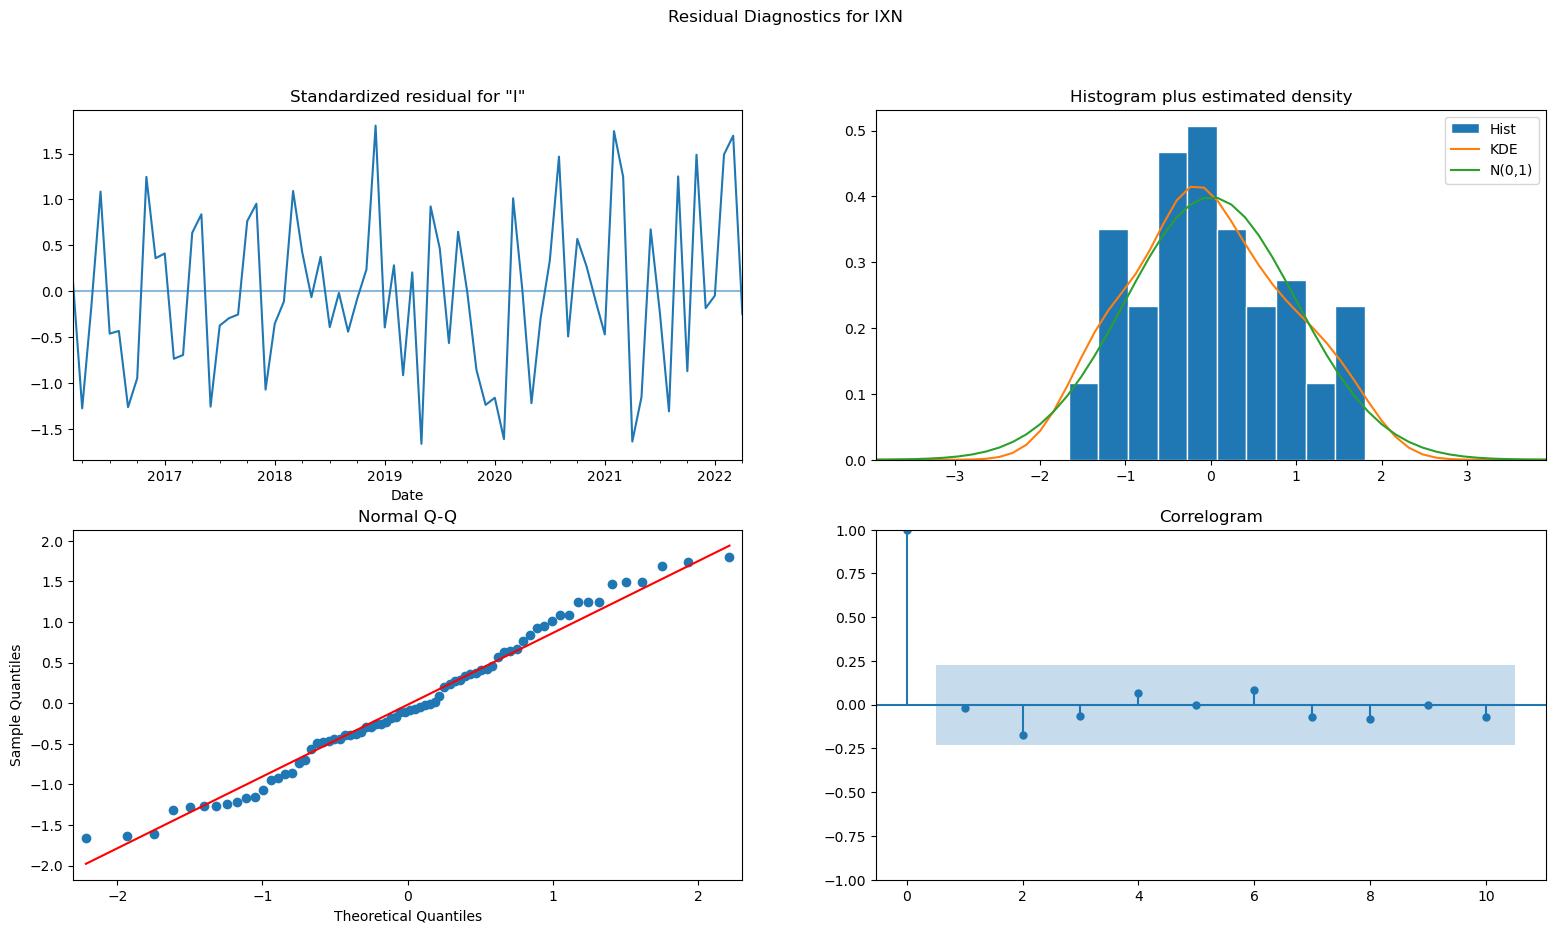

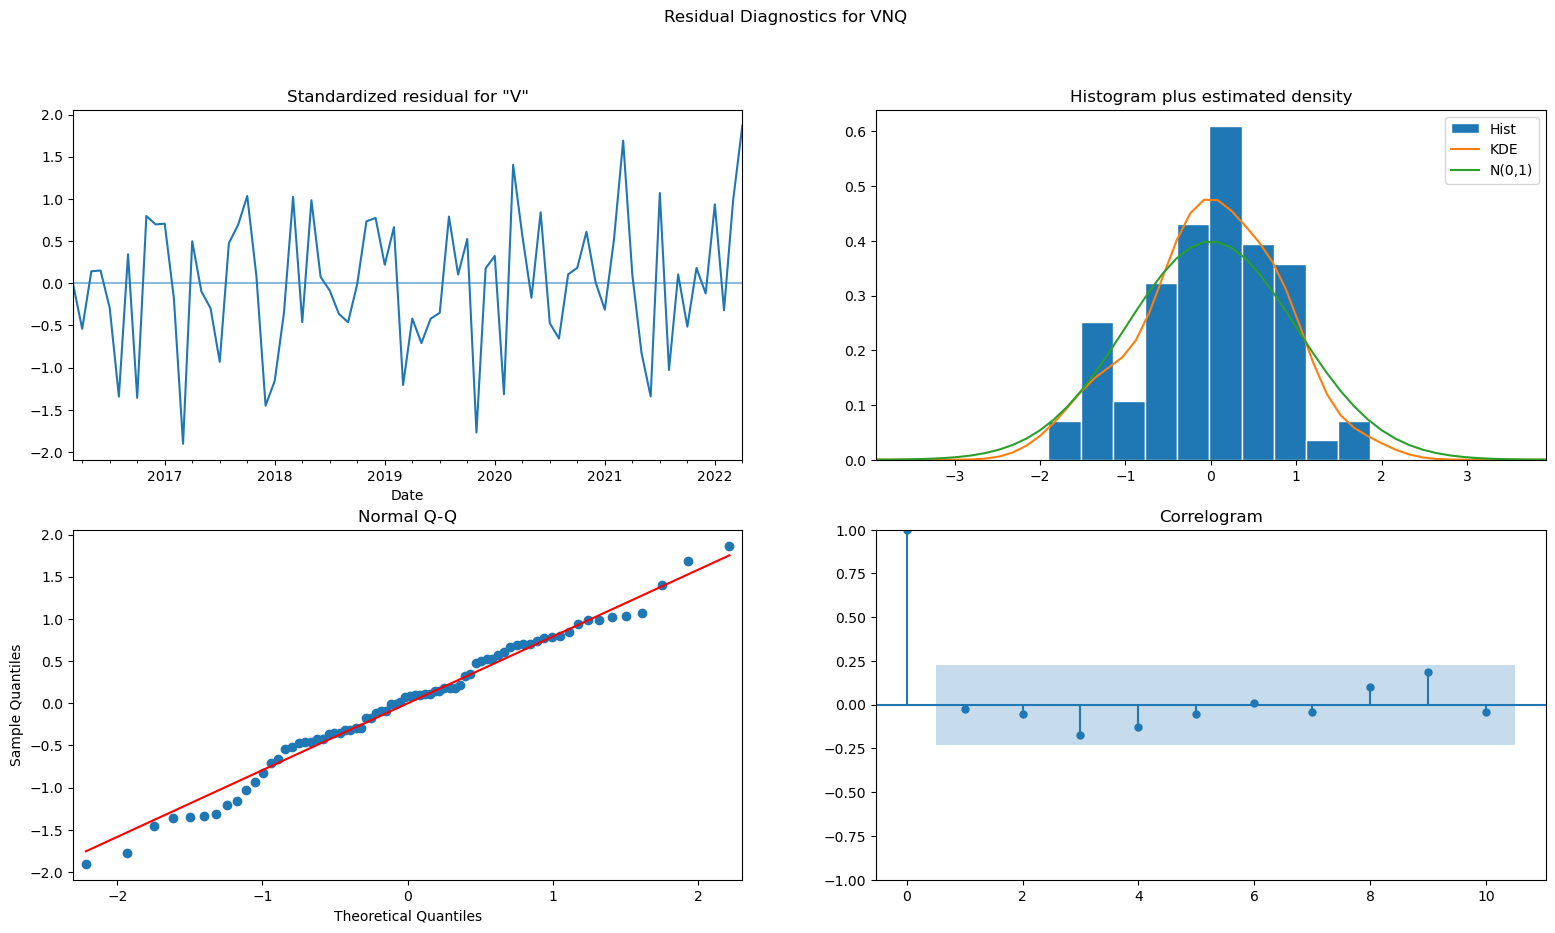

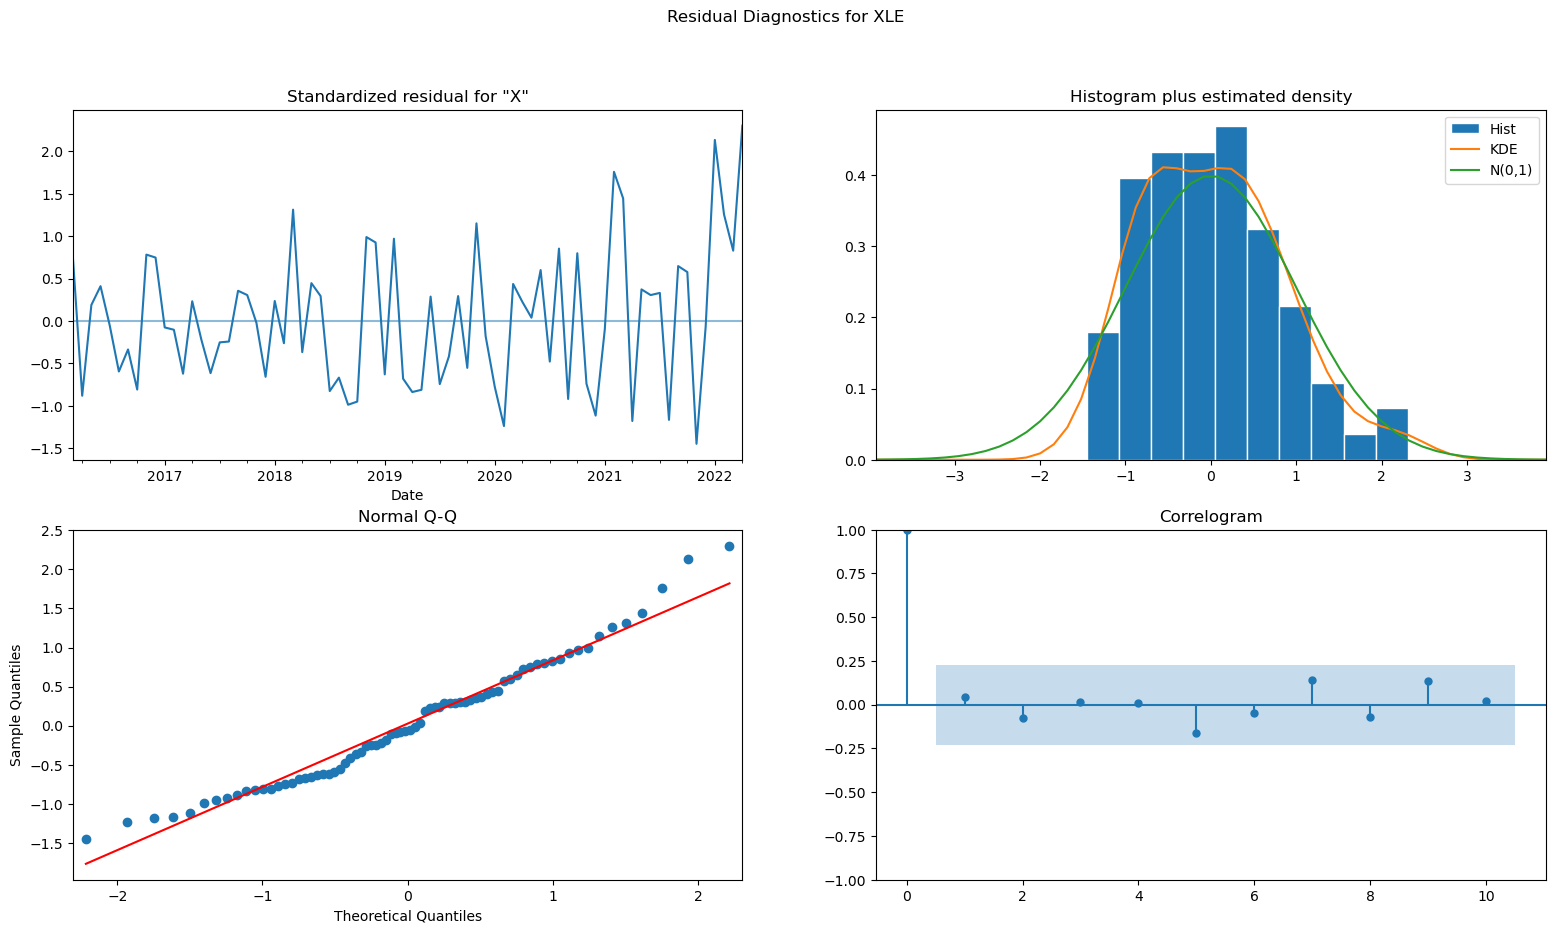

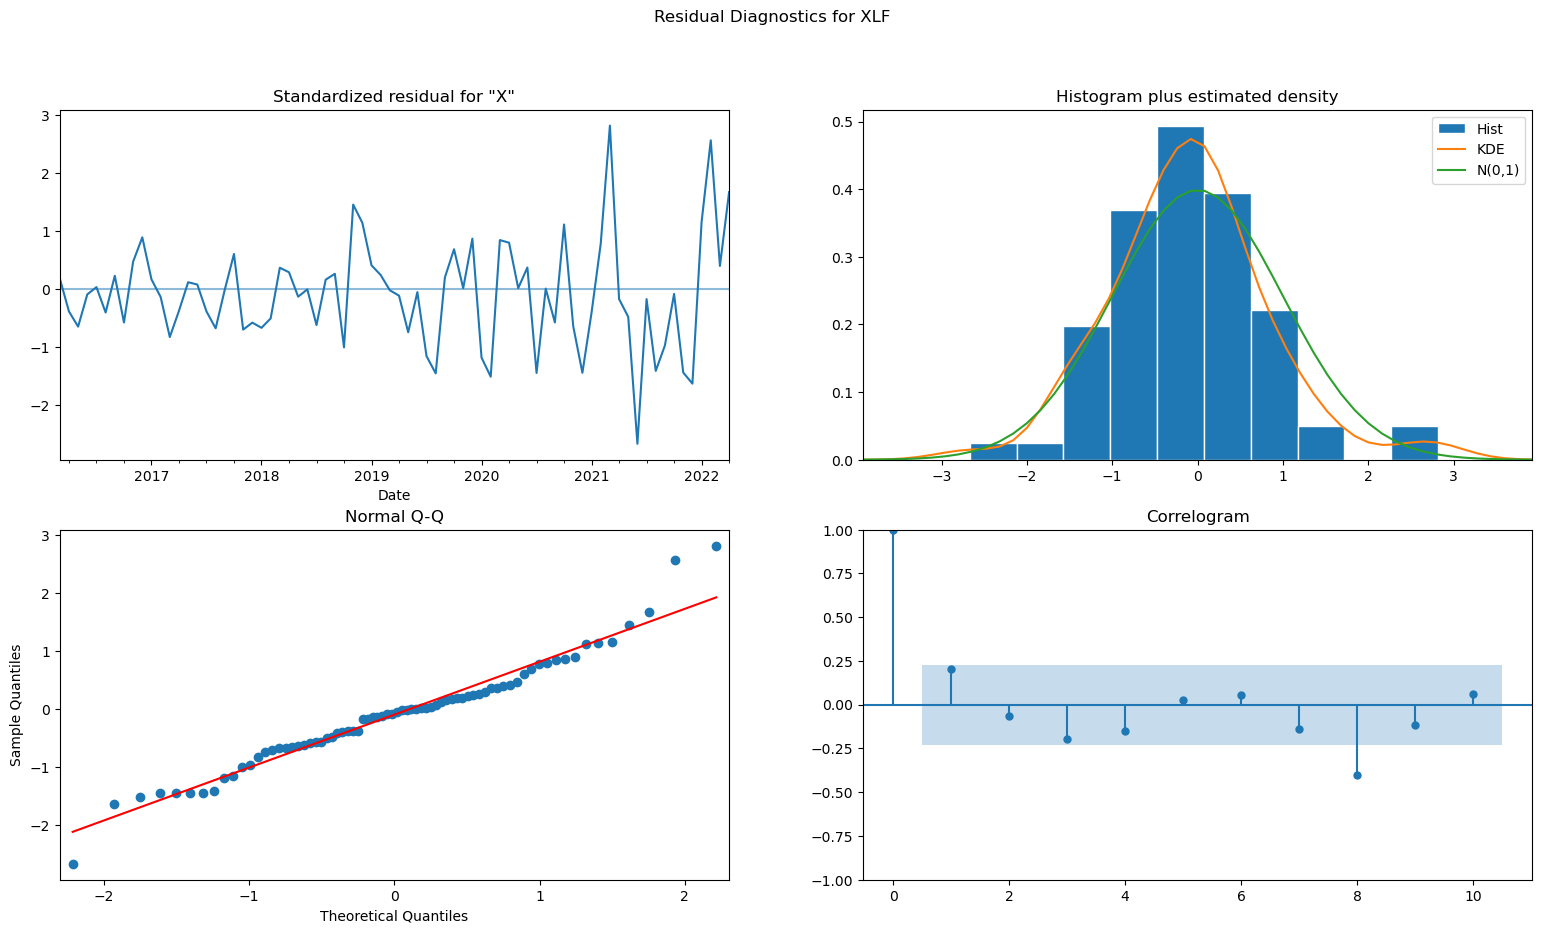

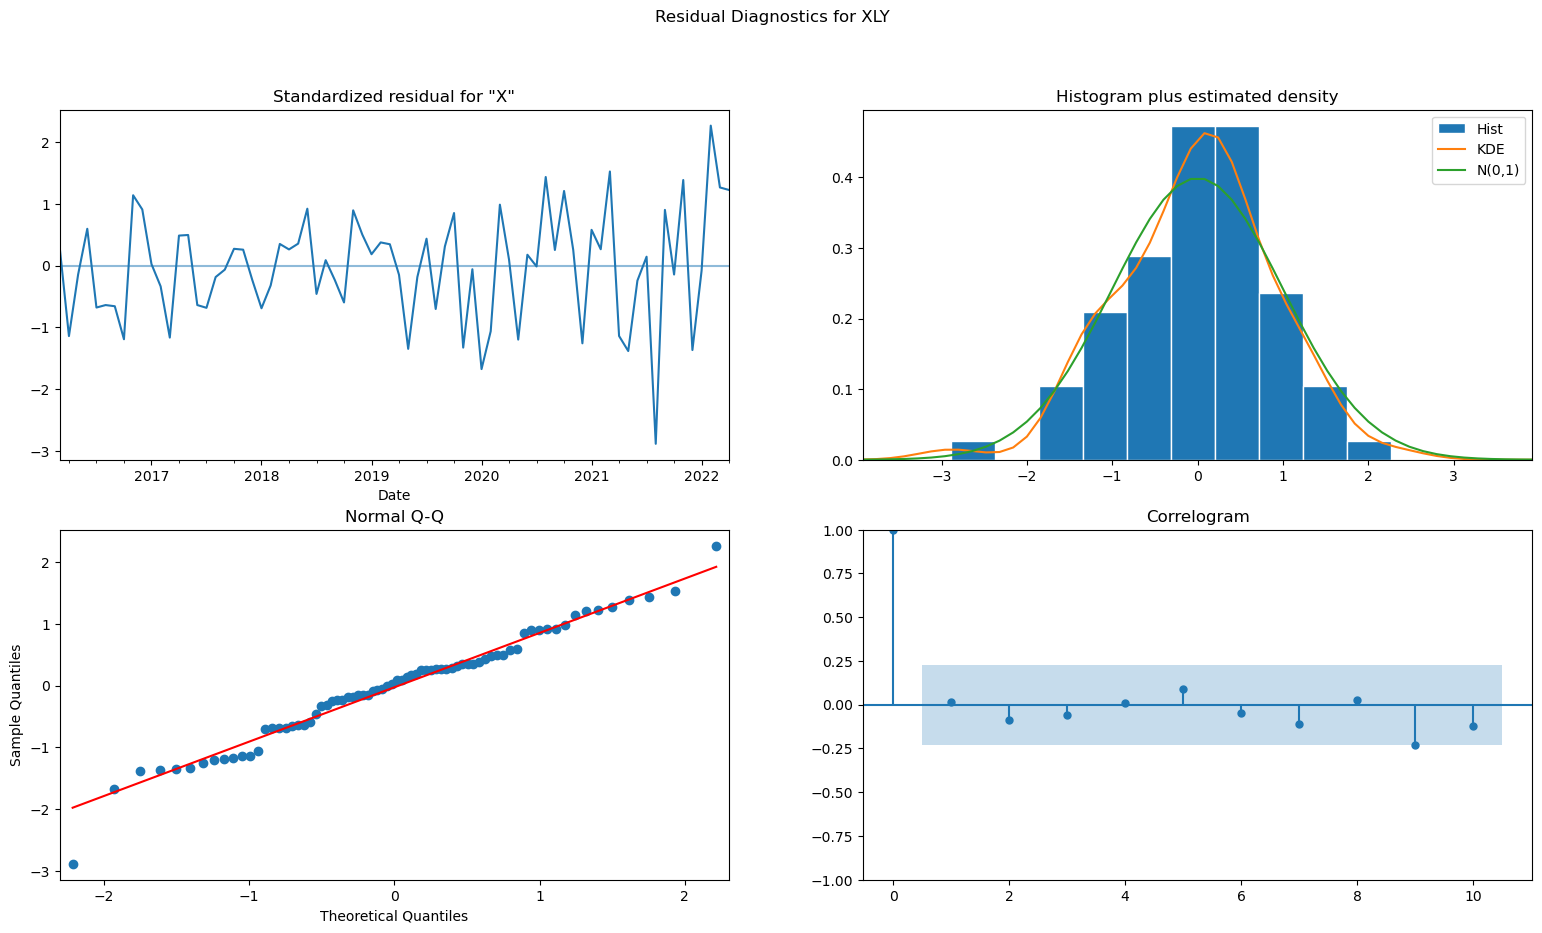

In [102]:
for item in etfs:
    sarimax_results[item].plot_diagnostics(figsize = [19,10])
    plt.suptitle(f'Residual Diagnostics for {item}')
    plt.tight_layout

#### Step 2: Using LjungBox Test

In [104]:
# Thumbs rule: if p value > 0.05, data is stationary
ljungbox_result = pd.DataFrame()

for item in etfs:
    residuals = sarimax_results[item].resid
    jungbox_df = acorr_ljungbox(residuals, lags=12)
    ljungbox_df = pd.DataFrame(jungbox_df[['lb_pvalue']])
    ljungbox_df.columns = [item]

    ljungbox_result = pd.concat([ljungbox_result, ljungbox_df], axis = 1)

ljungbox_result

,IXN,VNQ,XLE,XLF,XLY
1,0.766612,0.841426,0.822933,0.939513,0.911187
2,0.948976,0.975201,0.933263,0.996054,0.981270
3,0.991262,0.996082,0.986373,0.999687,0.998013
4,0.993830,0.999546,0.996679,0.999974,0.999631
5,0.994137,0.999643,0.999375,0.999999,0.999953
6,0.993251,0.999778,0.999837,1.000000,0.999995
7,0.997036,0.999819,0.999972,1.000000,0.999999
8,0.998913,0.999906,0.999980,1.000000,1.000000
9,0.992760,0.999875,0.999988,1.000000,1.000000
10,0.996601,0.999968,0.999997,1.000000,1.000000


### Part 9: Forecasting

In [115]:
# Naive forecast (baseline model)
def naive_forecast(test_data):
    naive_pred = [test_data[0]]  # No prediction for the first value
    
    # For each period, the naive forecast is simply the previous period's actual value
    for i in range(1, len(test_data)):
        naive_pred.append(test_data[i-1])
    
    return naive_pred

In [106]:
!pip install skforecast --upgrade

/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=1908) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [107]:
from skforecast.ForecasterSarimax import ForecasterSarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [110]:
# Using forecaster sarimax to forecast

def forecaster(prop, endog, exog, horizon, order, seasonal_order):
    
    forecaster = ForecasterSarimax(regressor=Sarimax(order=order, seasonal_order=seasonal_order))
    
    # Fit the model on the first `prop` proportion of the data
    forecaster.fit(y=endog[:prop], exog=exog[:prop], suppress_warnings=True)
    
    # Ensure there are enough exogenous variables for prediction
    if prop + horizon > len(exog):
        raise ValueError("Insufficient data in exog for the given horizon.")
         
    # Prediction for the given horizon
    sarimax_pred = forecaster.predict_interval(steps=horizon, exog=exog[prop:prop + horizon], alpha=0.05)

    return sarimax_pred

In [112]:
# Using sarimax predict 

def prediction (prop, endog, exog, horizon, order, seasonal_order):

    modelSARIMA = SARIMAX(endog=endog[:prop], exog=exog[:prop], order=order, seasonal_order=seasonal_order)
    model_fit = modelSARIMA.fit(disp=False, maxiter= 1000, method='powell')
    forecast_results = model_fit.get_forecast(steps=horizon, exog=exog[prop:prop + horizon])

    predicted_mean = forecast_results.predicted_mean
    
    # Extract the confidence intervals (upper and lower bounds)
    conf_int = forecast_results.conf_int()
    
    # Create a DataFrame with the predictions and confidence intervals
    forecast_df = pd.DataFrame({
        'predicted_mean': predicted_mean,
        'lower_bound': conf_int.iloc[:, 0],  # Lower bound of the interval
        'upper_bound': conf_int.iloc[:, 1]   # Upper bound of the interval
    })

    forecast_df['actual'] = endog.iloc[prop: ]
    
    return forecast_df

#### ETF 1: IXN

In [115]:
# Forecaster SARIMAX
# Defined the input variables
ixn_test_data = diff_2_df['IXN'].iloc[prop: ]
ixn_train_data = diff_2_df['IXN'].iloc[ : prop]
ixn_horizon = len(ixn_test_data)
ixn_endog = diff_2_df['IXN']
ixn_order_forecaster = ixn_SARIMA_model.order
ixn_seasonal_order_forecaster = ixn_SARIMA_model.seasonal_order

ixn_pred_df = pd.DataFrame({'Actual values': ixn_test_data})

ixn_pred_forecaster = forecaster(prop, 
                                 ixn_endog, 
                                 exog_trim_aligned, 
                                 ixn_horizon, 
                                 ixn_order_forecaster, 
                                 ixn_seasonal_order_forecaster)

ixn_pred_forecaster['actual'] = diff_2_df['IXN'].iloc[prop: ]
ixn_pred_forecaster

,pred,lower_bound,upper_bound,actual
2022-05-31,-16.229482,-20.765512,-11.693453,-2.701292
2022-06-30,-17.106536,-22.901067,-11.312004,-4.329888
2022-07-31,-20.034214,-26.858995,-13.209434,-2.522303
2022-08-31,-17.177584,-24.896306,-9.458863,2.481149
2022-09-30,-19.845409,-28.364780,-11.326037,-6.206790
2022-10-31,-23.792592,-33.043577,-14.541607,-1.200573
2022-11-30,-18.712599,-28.641434,-8.783764,-1.217142
2022-12-31,-20.411832,-30.975108,-9.848556,-1.149666
2023-01-31,-22.636807,-33.798519,-11.475094,4.056011
2023-02-28,-18.750438,-30.480095,-7.020781,5.969696


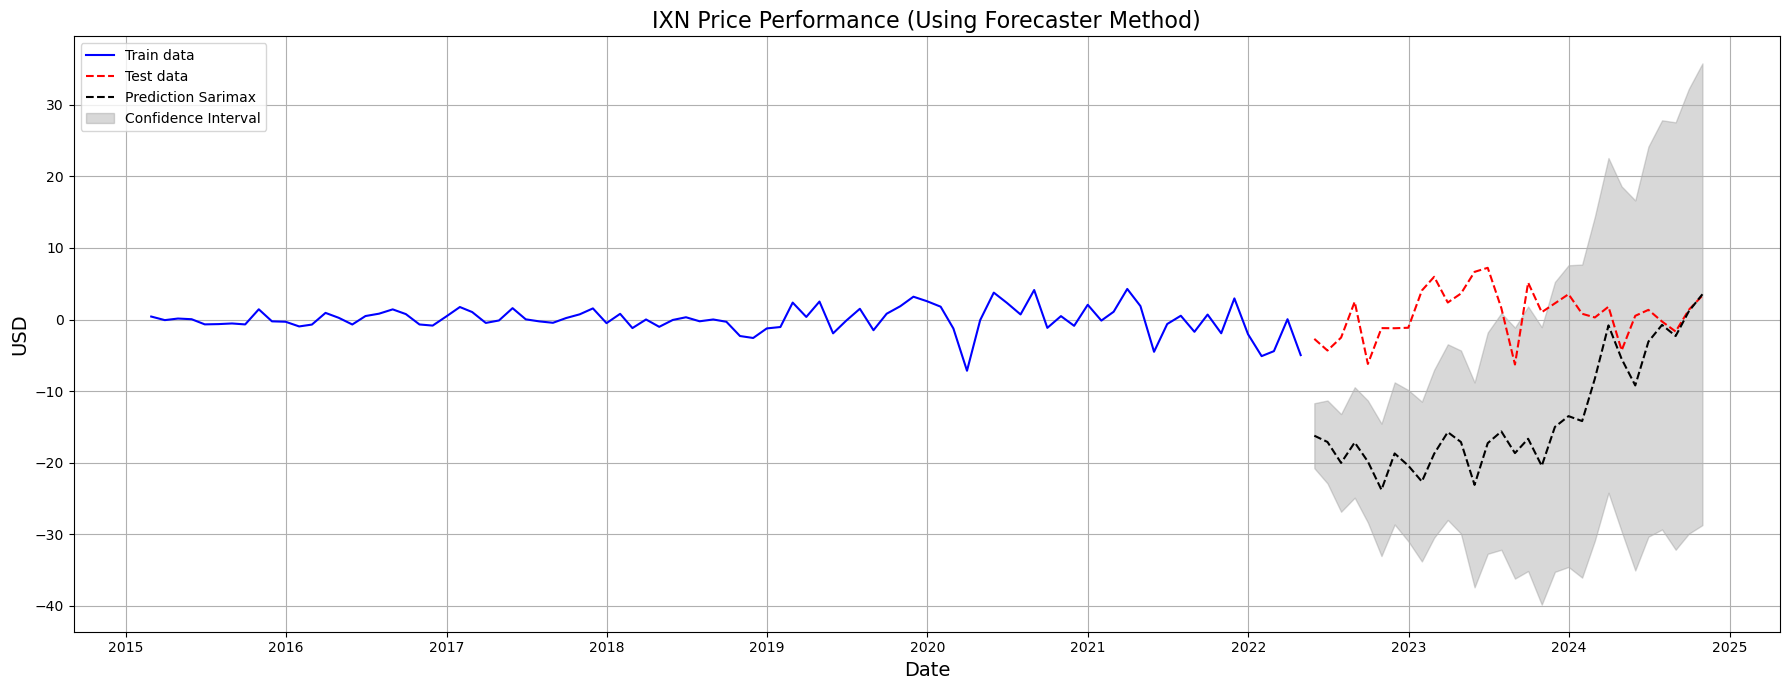

In [117]:
# Plot using forecaster results
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(ixn_train_data.index, ixn_train_data, label='Train data', color='blue')
ax.plot(ixn_pred_forecaster.index, ixn_pred_forecaster['actual'], 'r--', label='Test data')
ax.plot(ixn_pred_forecaster.index, ixn_pred_forecaster['pred'], 'k--', label='Prediction Sarimax')

ax.fill_between(ixn_pred_forecaster.index, ixn_pred_forecaster['lower_bound'], ixn_pred_forecaster['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('IXN Price Performance (Using Forecaster Method)', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

In [119]:
# .predict() SARIMAX
# Defined the input variables
ixn_pred_sarimax = prediction(prop,
                              ixn_endog, 
                              exog_trim_aligned, 
                              ixn_horizon, 
                              ixn_order_forecaster, 
                              ixn_seasonal_order_forecaster)
ixn_pred_sarimax

,predicted_mean,lower_bound,upper_bound,actual
2022-05-31,-7.691772,-10.235482,-5.148063,-2.701292
2022-06-30,-10.239925,-12.783634,-7.696215,-4.329888
2022-07-31,-14.119008,-16.662718,-11.575299,-2.522303
2022-08-31,-11.768755,-14.312464,-9.225045,2.481149
2022-09-30,-15.087236,-17.630945,-12.543526,-6.206790
2022-10-31,-14.907207,-17.450917,-12.363498,-1.200573
2022-11-30,-16.326695,-18.870404,-13.782985,-1.217142
2022-12-31,-16.248087,-18.791796,-13.704377,-1.149666
2023-01-31,-17.903256,-20.446966,-15.359547,4.056011
2023-02-28,-18.873988,-21.417698,-16.330279,5.969696


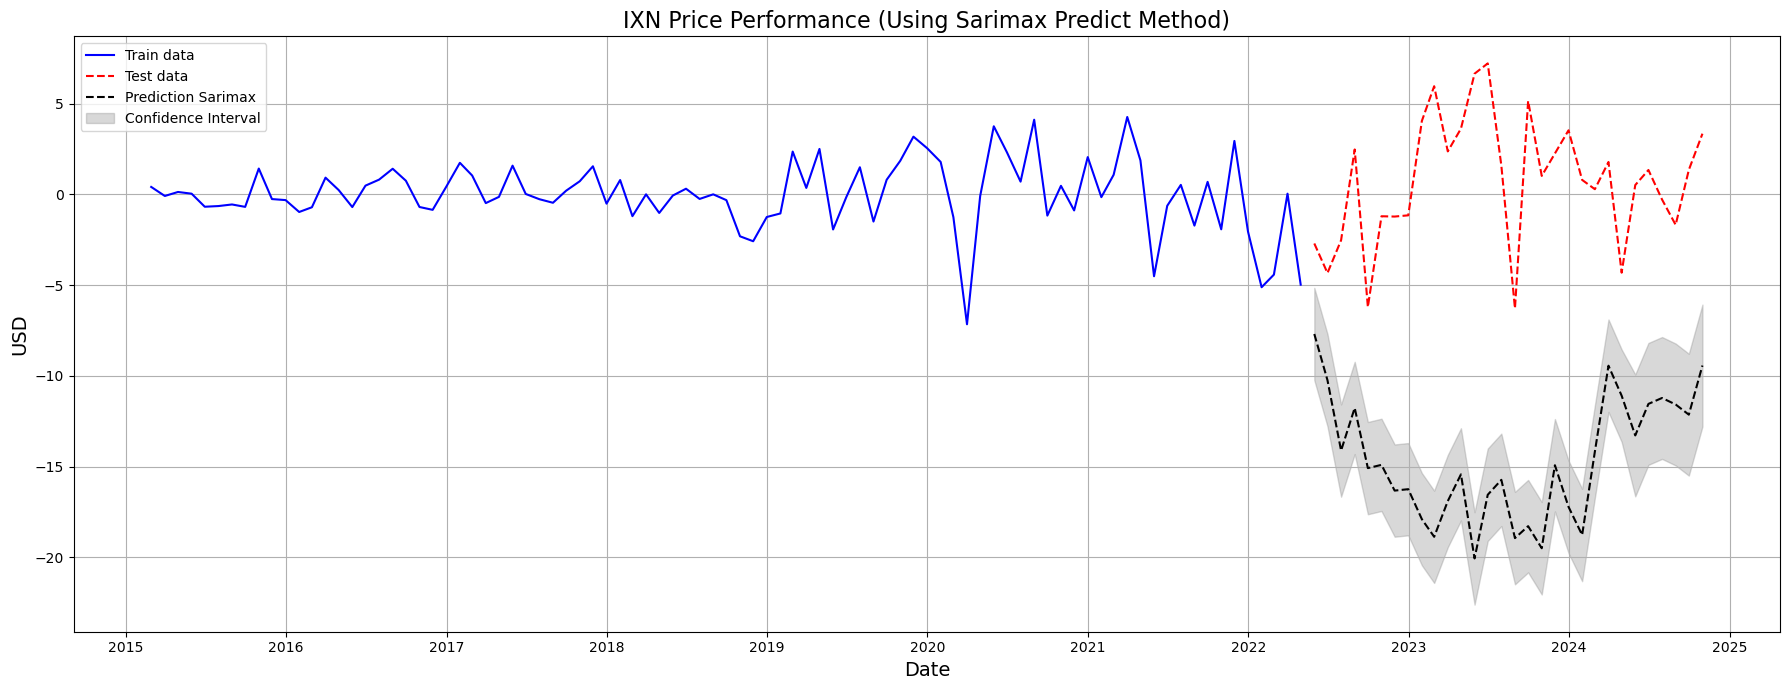

In [121]:
# Plot using sarimax predict
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(ixn_train_data.index, ixn_train_data, label='Train data', color='blue')
ax.plot(ixn_pred_sarimax.index, ixn_pred_sarimax['actual'], 'r--', label='Test data')
ax.plot(ixn_pred_sarimax.index, ixn_pred_sarimax['predicted_mean'], 'k--', label='Prediction Sarimax')

ax.fill_between(ixn_pred_sarimax.index, ixn_pred_sarimax['lower_bound'], ixn_pred_sarimax['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('IXN Price Performance (Using Sarimax Predict Method)', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

#### ETF 2: VNQ

In [123]:
# Forecaster SARIMAX
# Defined the input variables
vnq_test_data = diff_2_df['VNQ'].iloc[prop: ]
vnq_train_data = diff_2_df['VNQ'].iloc[ : prop]
vnq_horizon = len(vnq_test_data)
vnq_endog = diff_2_df['VNQ']
vnq_order_forecaster = vnq_SARIMA_model.order
vnq_seasonal_order_forecaster = vnq_SARIMA_model.seasonal_order

vnq_pred_df = pd.DataFrame({'Actual values': vnq_test_data})

vnq_pred_forecaster = forecaster(prop, 
                                 vnq_endog, 
                                 exog_trim_aligned, 
                                 vnq_horizon, 
                                 vnq_order_forecaster, 
                                 vnq_seasonal_order_forecaster)

vnq_pred_forecaster['actual'] = diff_2_df['VNQ'].iloc[prop: ]
vnq_pred_forecaster

,pred,lower_bound,upper_bound,actual
2022-05-31,-14.286019,-26.168155,-2.403884,-12.217067
2022-06-30,-24.825844,-38.761163,-10.890524,-9.389548
2022-07-31,-30.549674,-46.714730,-14.384618,-0.628945
2022-08-31,-28.544892,-46.660118,-10.429667,2.865861
2022-09-30,-31.840464,-51.690589,-11.990339,-8.839805
2022-10-31,-34.674927,-56.129385,-13.220468,-7.682747
2022-11-30,-38.278595,-61.223683,-15.333506,1.682926
2022-12-31,-39.273187,-63.617862,-14.928512,-1.673598
2023-01-31,-35.787046,-61.455188,-10.118904,5.066219
2023-02-28,-43.400590,-70.326932,-16.474248,6.588563


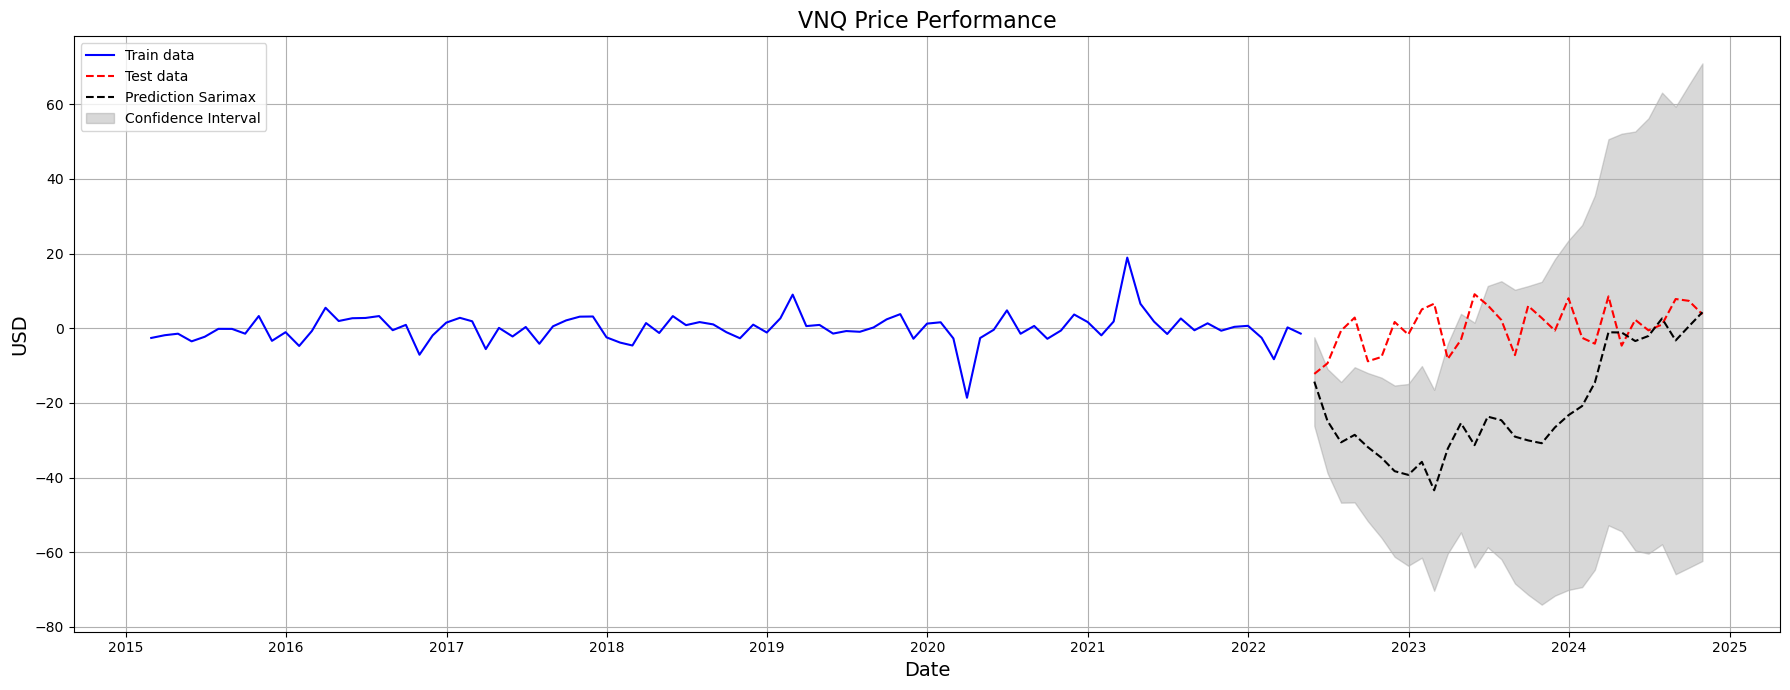

In [125]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(vnq_train_data.index, vnq_train_data, label='Train data', color='blue')
ax.plot(vnq_pred_forecaster.index, vnq_pred_forecaster['actual'], 'r--', label='Test data')
ax.plot(vnq_pred_forecaster.index, vnq_pred_forecaster['pred'], 'k--', label='Prediction Sarimax')

ax.fill_between(vnq_pred_forecaster.index, vnq_pred_forecaster['lower_bound'], vnq_pred_forecaster['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('VNQ Price Performance', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

In [127]:
# .predict() SARIMAX
# Defined the input variables
vnq_pred_sarimax = prediction(prop,
                              vnq_endog, 
                              exog_trim_aligned, 
                              vnq_horizon, 
                              vnq_order_forecaster, 
                              vnq_seasonal_order_forecaster)
vnq_pred_sarimax

,predicted_mean,lower_bound,upper_bound,actual
2022-05-31,-11.955302,-19.772221,-4.138383,-12.217067
2022-06-30,-15.130464,-23.919187,-6.341742,-9.389548
2022-07-31,-22.867999,-32.698431,-13.037566,-0.628945
2022-08-31,-20.431904,-31.427376,-9.436432,2.865861
2022-09-30,-21.176684,-33.095549,-9.257819,-8.839805
2022-10-31,-20.171654,-32.969415,-7.373892,-7.682747
2022-11-30,-23.920533,-37.551291,-10.289775,1.682926
2022-12-31,-25.817147,-40.224218,-11.410076,-1.673598
2023-01-31,-26.884862,-42.030549,-11.739175,5.066219
2023-02-28,-32.347355,-48.194288,-16.500421,6.588563


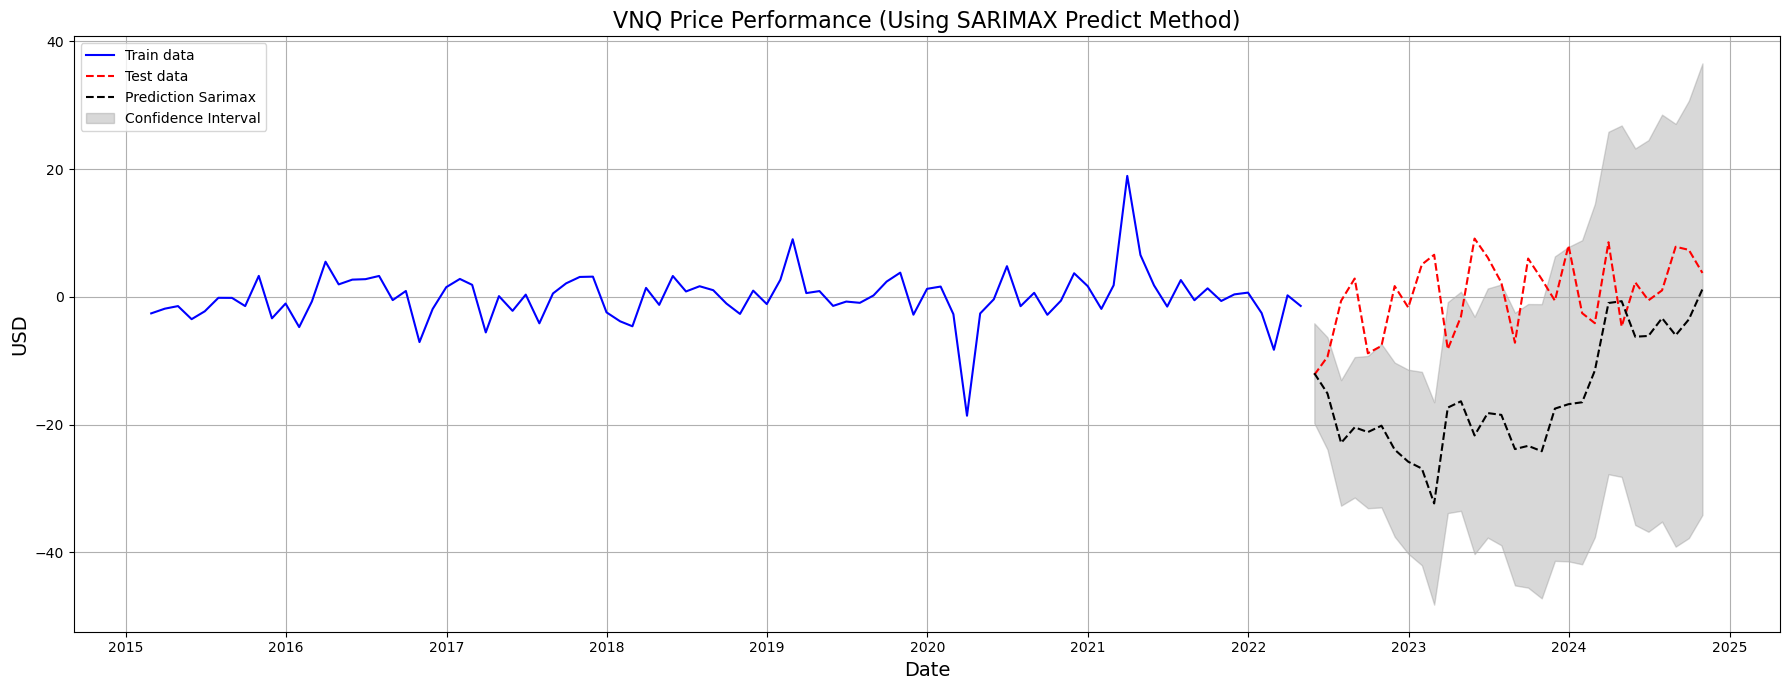

In [129]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(vnq_train_data.index, vnq_train_data, label='Train data', color='blue')
ax.plot(vnq_pred_sarimax.index, vnq_pred_sarimax['actual'], 'r--', label='Test data')
ax.plot(vnq_pred_sarimax.index, vnq_pred_sarimax['predicted_mean'], 'k--', label='Prediction Sarimax')

ax.fill_between(vnq_pred_sarimax.index, vnq_pred_sarimax['lower_bound'], vnq_pred_sarimax['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('VNQ Price Performance (Using SARIMAX Predict Method)', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

#### ETF 3: XLE

In [131]:
# Forecaster SARIMAX
# Defined the input variables
xle_test_data = diff_2_df['XLE'].iloc[prop: ]
xle_train_data = diff_2_df['XLE'].iloc[ : prop]
xle_horizon = len(xle_test_data)
xle_endog = diff_2_df['XLE']
xle_order_forecaster = xle_SARIMA_model.order
xle_seasonal_order_forecaster = xle_SARIMA_model.seasonal_order

xle_pred_df = pd.DataFrame({'Actual values': xle_test_data})

xle_pred_forecaster = forecaster(prop, 
                                 xle_endog, 
                                 exog_trim_aligned, 
                                 xle_horizon, 
                                 xle_order_forecaster, 
                                 xle_seasonal_order_forecaster)

xle_pred_forecaster['actual'] = diff_2_df['XLE'].iloc[prop: ]
xle_pred_forecaster

,pred,lower_bound,upper_bound,actual
2022-05-31,-13.307198,-27.340797,0.726402,0.835758
2022-06-30,-22.702516,-39.950767,-5.454264,-3.053113
2022-07-31,-32.765827,-52.717329,-12.814325,-4.851455
2022-08-31,-20.231535,-42.561396,2.098326,8.132262
2022-09-30,-28.087865,-52.566079,-3.609651,-1.954356
2022-10-31,-29.796192,-56.248853,-3.343532,-0.174558
2022-11-30,-27.954798,-56.244434,0.334837,7.027784
2022-12-31,-22.655414,-52.669807,7.358978,-3.347538
2023-01-31,-19.273408,-50.918692,12.371877,-4.104886
2023-02-28,-22.611944,-55.808093,10.584205,-7.260005


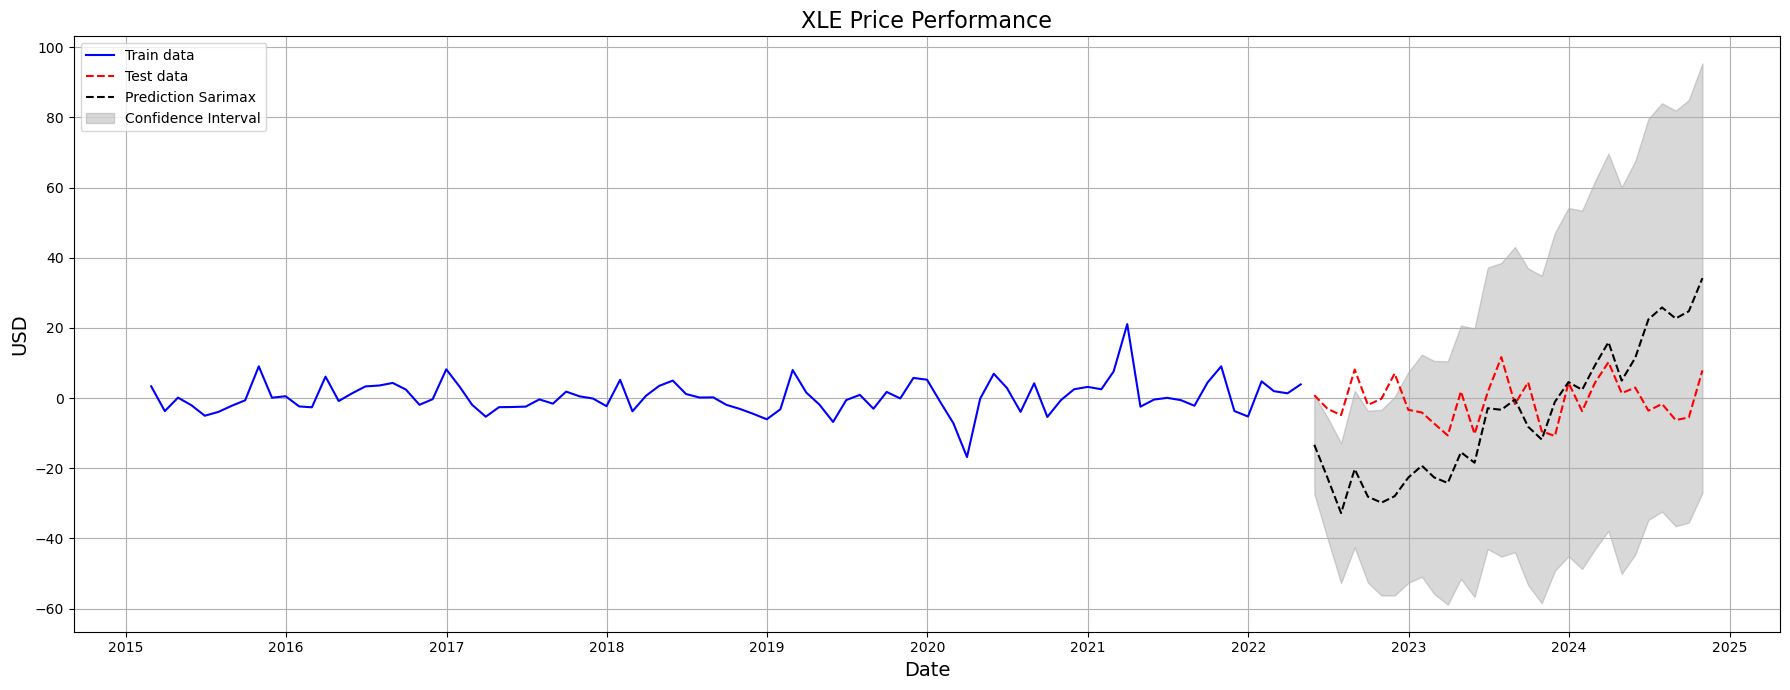

In [133]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(xle_train_data.index, xle_train_data, label='Train data', color='blue')
ax.plot(xle_pred_forecaster.index, xle_pred_forecaster['actual'], 'r--', label='Test data')
ax.plot(xle_pred_forecaster.index, xle_pred_forecaster['pred'], 'k--', label='Prediction Sarimax')

ax.fill_between(xle_pred_forecaster.index, xle_pred_forecaster['lower_bound'], xle_pred_forecaster['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('XLE Price Performance', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

In [137]:
# .predict() SARIMAX
# Defined the input variables
xle_pred_sarimax = prediction(prop,
                              xle_endog, 
                              exog_trim_aligned, 
                              xle_horizon, 
                              xle_order_forecaster, 
                              xle_seasonal_order_forecaster)
xle_pred_sarimax

,predicted_mean,lower_bound,upper_bound,actual
2022-05-31,-3.507294,-11.325196,4.310607,0.835758
2022-06-30,-2.585016,-10.402917,5.232886,-3.053113
2022-07-31,-8.853227,-16.671129,-1.035326,-4.851455
2022-08-31,-7.717054,-15.534956,0.100847,8.132262
2022-09-30,-13.849624,-21.667525,-6.031723,-1.954356
2022-10-31,-15.400520,-23.218421,-7.582618,-0.174558
2022-11-30,-13.923808,-21.741709,-6.105907,7.027784
2022-12-31,-15.579587,-23.397488,-7.761685,-3.347538
2023-01-31,-19.428035,-27.245936,-11.610133,-4.104886
2023-02-28,-20.358610,-28.176512,-12.540709,-7.260005


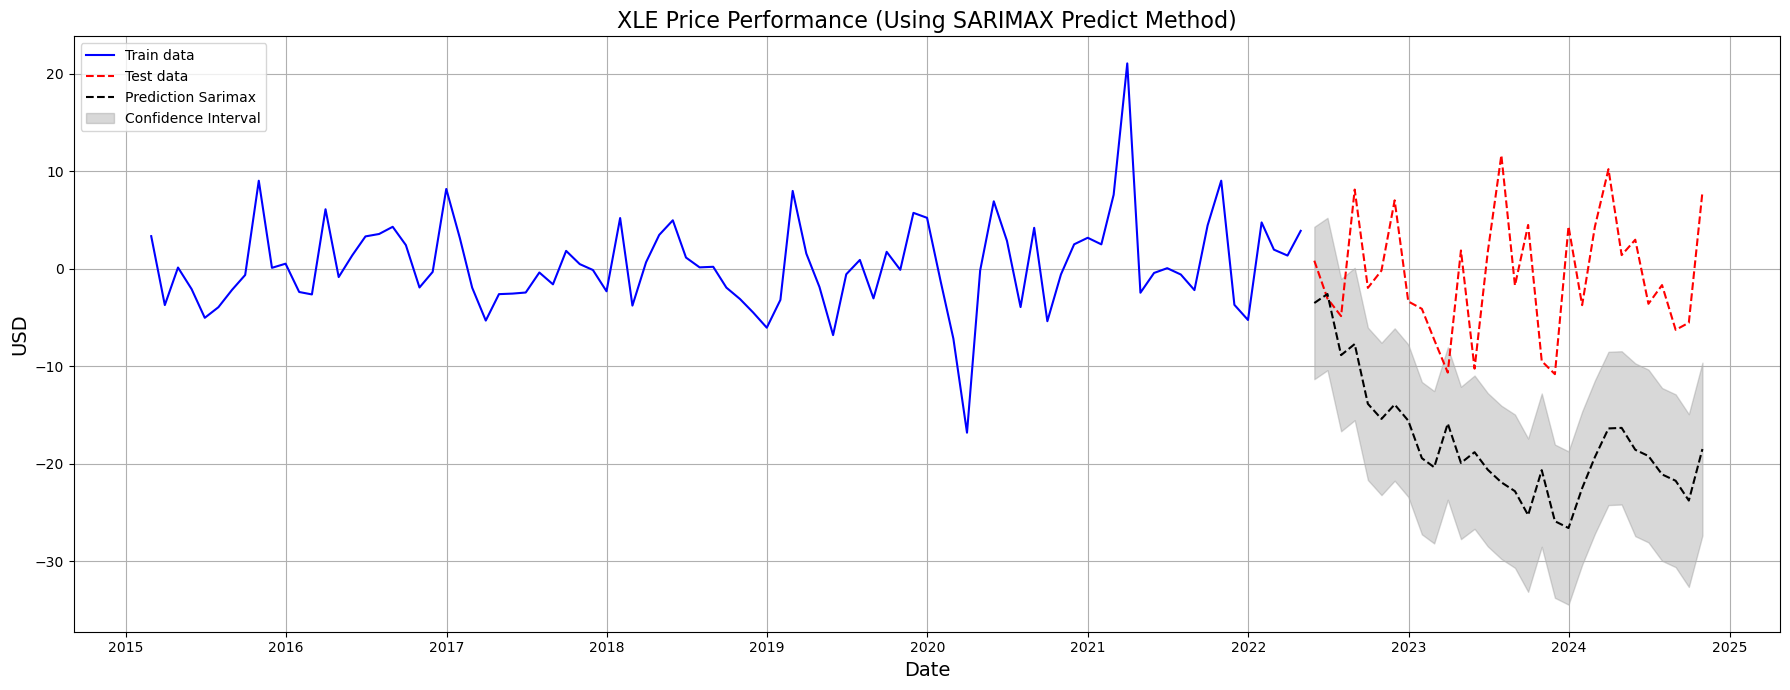

In [138]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(xle_train_data.index, xle_train_data, label='Train data', color='blue')
ax.plot(xle_pred_sarimax.index, xle_pred_sarimax['actual'], 'r--', label='Test data')
ax.plot(xle_pred_sarimax.index, xle_pred_sarimax['predicted_mean'], 'k--', label='Prediction Sarimax')

ax.fill_between(xle_pred_sarimax.index, xle_pred_sarimax['lower_bound'], xle_pred_sarimax['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('XLE Price Performance (Using SARIMAX Predict Method)', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

#### ETF 4: XLF

In [141]:
# Forecaster SARIMAX
# Defined the input variables
xlf_test_data = diff_2_df['XLF'].iloc[prop: ]
xlf_train_data = diff_2_df['XLF'].iloc[ : prop]
xlf_horizon = len(xlf_test_data)
xlf_endog = diff_2_df['XLF']
xlf_order_forecaster = xlf_SARIMA_model.order
xlf_seasonal_order_forecaster = xlf_SARIMA_model.seasonal_order

xlf_pred_df = pd.DataFrame({'Actual values': xlf_test_data})

xlf_pred_forecaster = forecaster(prop, 
                                 xlf_endog, 
                                 exog_trim_aligned, 
                                 xlf_horizon, 
                                 xlf_order_forecaster, 
                                 xlf_seasonal_order_forecaster)

xlf_pred_forecaster['actual'] = diff_2_df['XLF'].iloc[prop: ]
xlf_pred_forecaster

,pred,lower_bound,upper_bound,actual
2022-05-31,-9.378726,-13.844177,-4.913275,-4.714893
2022-06-30,-12.495846,-17.155402,-7.836291,-1.242809
2022-07-31,-14.015807,-19.377909,-8.653705,0.301161
2022-08-31,-10.180516,-16.262867,-4.098166,0.475043
2022-09-30,-13.450178,-19.880420,-7.019936,-1.467674
2022-10-31,-15.229058,-22.223184,-8.234933,-2.006486
2022-11-30,-13.247883,-20.663554,-5.832212,2.615405
2022-12-31,-13.126432,-20.933857,-5.319007,0.297823
2023-01-31,-11.852663,-20.079469,-3.625857,0.121368
2023-02-28,-12.103344,-20.689363,-3.517325,0.960163


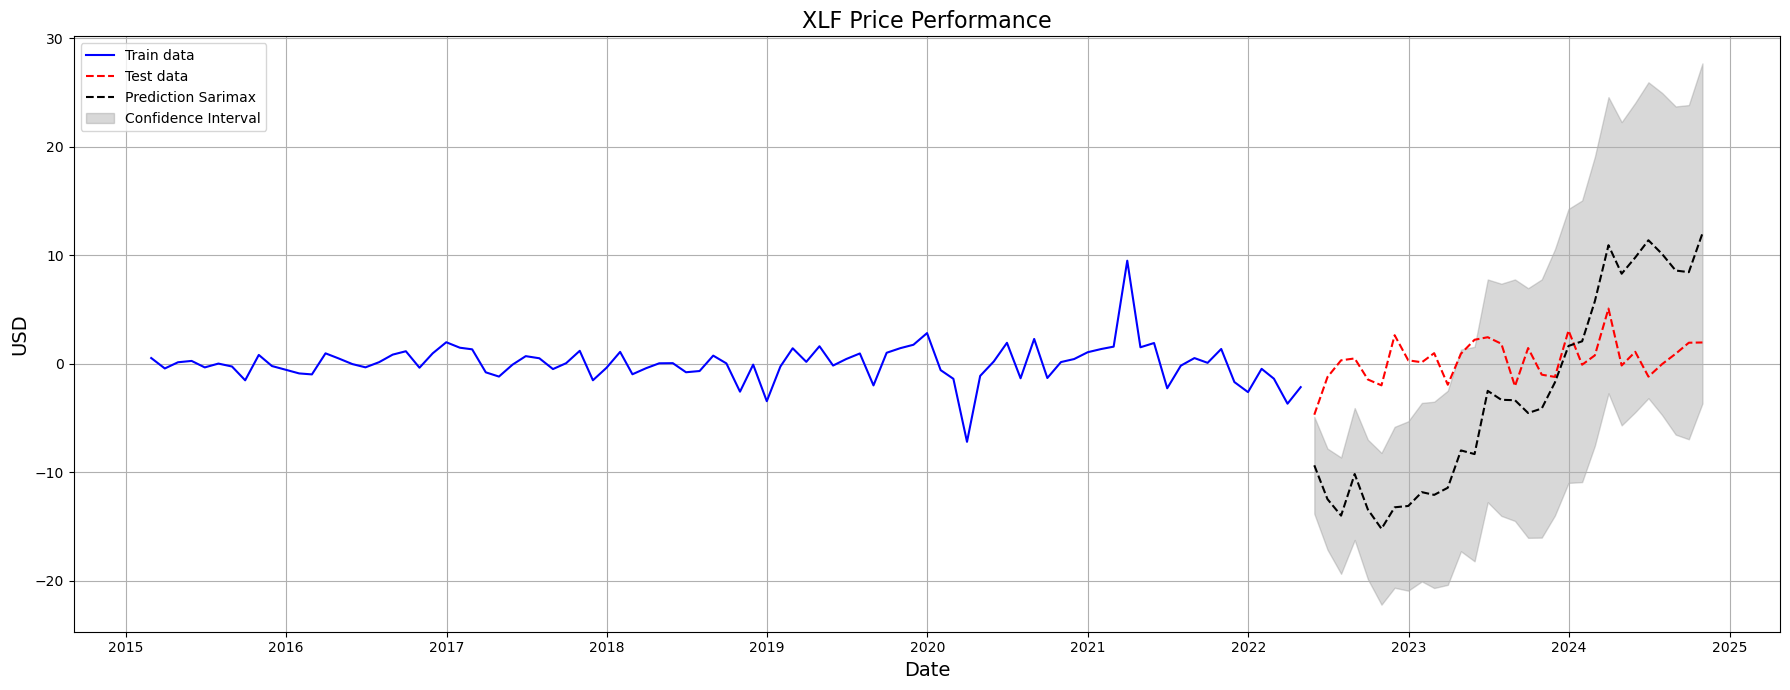

In [143]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(xlf_train_data.index, xlf_train_data, label='Train data', color='blue')
ax.plot(xlf_pred_forecaster.index, xlf_pred_forecaster['actual'], 'r--', label='Test data')
ax.plot(xlf_pred_forecaster.index, xlf_pred_forecaster['pred'], 'k--', label='Prediction Sarimax')

ax.fill_between(xlf_pred_forecaster.index, xlf_pred_forecaster['lower_bound'], xlf_pred_forecaster['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('XLF Price Performance', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

In [151]:
# .predict() SARIMAX
# Defined the input variables
xlf_pred_sarimax = prediction(prop,
                              xlf_endog, 
                              exog_trim_aligned, 
                              xlf_horizon, 
                              xlf_order_forecaster, 
                              xlf_seasonal_order_forecaster)
xlf_pred_sarimax

,predicted_mean,lower_bound,upper_bound,actual
2022-05-31,-6.730077,-9.824558,-3.635597,-4.714893
2022-06-30,-6.777066,-9.920036,-3.634097,-1.242809
2022-07-31,-11.947264,-15.425686,-8.468842,0.301161
2022-08-31,-10.993771,-14.728994,-7.258549,0.475043
2022-09-30,-13.311893,-17.289280,-9.334505,-1.467674
2022-10-31,-13.467505,-17.657591,-9.277419,-2.006486
2022-11-30,-15.508177,-19.916110,-11.100245,2.615405
2022-12-31,-15.989030,-20.597471,-11.380589,0.297823
2023-01-31,-16.349379,-21.151561,-11.547198,0.121368
2023-02-28,-17.541919,-22.530134,-12.553705,0.960163


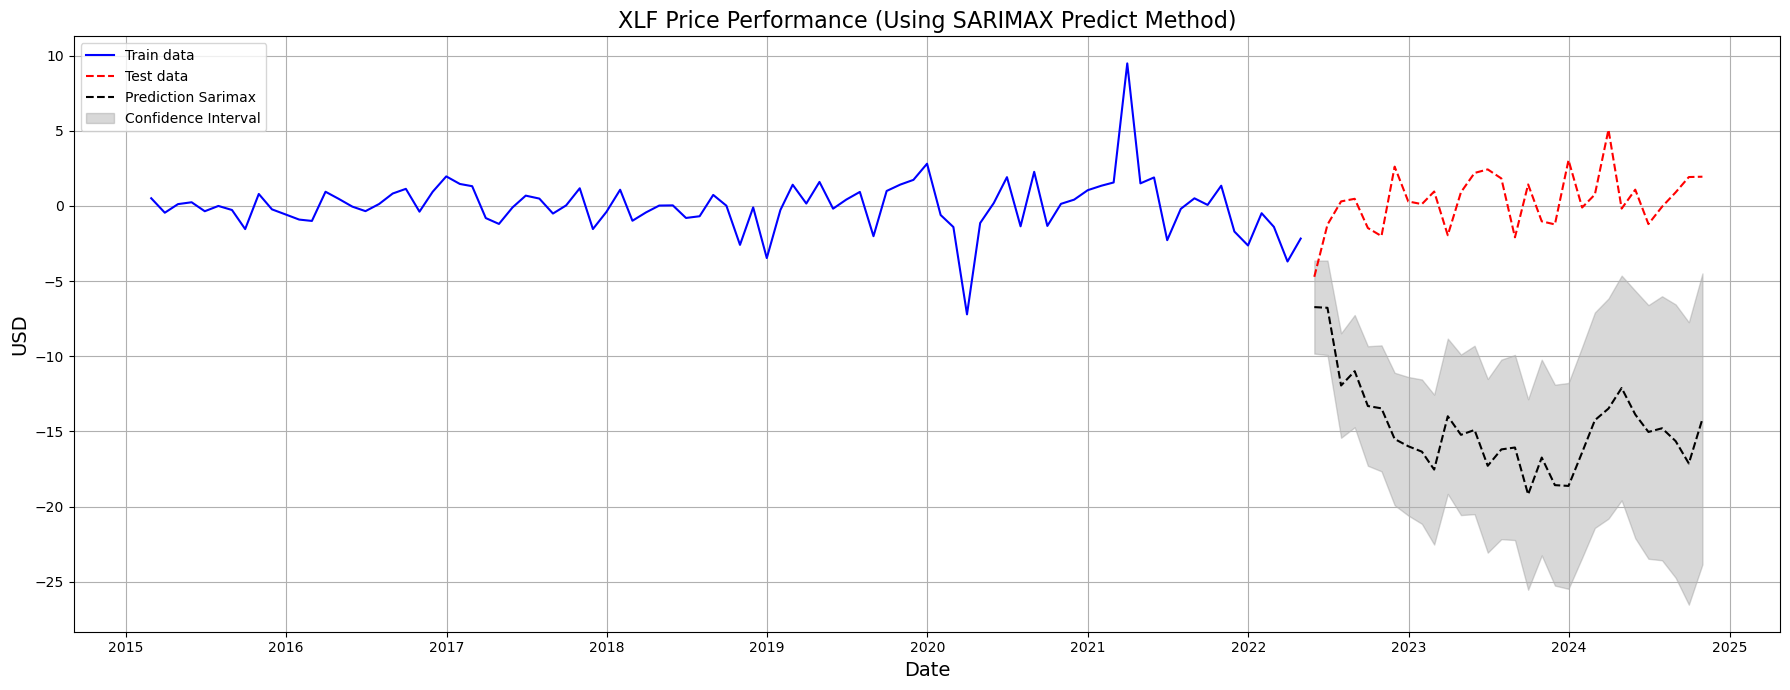

In [153]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(xlf_train_data.index, xlf_train_data, label='Train data', color='blue')
ax.plot(xlf_pred_sarimax.index, xlf_pred_sarimax['actual'], 'r--', label='Test data')
ax.plot(xlf_pred_sarimax.index, xlf_pred_sarimax['predicted_mean'], 'k--', label='Prediction Sarimax')

ax.fill_between(xlf_pred_sarimax.index, xlf_pred_sarimax['lower_bound'], xlf_pred_sarimax['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('XLF Price Performance (Using SARIMAX Predict Method)', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

#### ETF 5: XLY

In [155]:
# Forecaster SARIMAX
# Defined the input variables
xly_test_data = diff_2_df['XLY'].iloc[prop: ]
xly_train_data = diff_2_df['XLY'].iloc[ : prop]
xly_horizon = len(xly_test_data)
xly_endog = diff_2_df['XLY']
xly_order_forecaster = xly_SARIMA_model.order
xly_seasonal_order_forecaster = xly_SARIMA_model.seasonal_order

xly_pred_df = pd.DataFrame({'Actual values': xly_test_data})

xly_pred_forecaster = forecaster(prop, 
                                 xly_endog, 
                                 exog_trim_aligned, 
                                 xly_horizon, 
                                 xly_order_forecaster, 
                                 xly_seasonal_order_forecaster)

xly_pred_forecaster['actual'] = diff_2_df['XLY'].iloc[prop: ]
xly_pred_forecaster

,pred,lower_bound,upper_bound,actual
2022-05-31,-49.586169,-64.778313,-34.394026,-22.202743
2022-06-30,-56.827478,-75.046147,-38.608808,-8.322186
2022-07-31,-62.488549,-83.241275,-41.735824,-3.716786
2022-08-31,-52.100333,-74.604582,-29.596083,17.391791
2022-09-30,-61.879935,-86.416733,-37.343137,-12.317599
2022-10-31,-67.290568,-93.631413,-40.949723,-17.804101
2022-11-30,-52.747764,-80.807671,-24.687857,-19.565589
2022-12-31,-66.514275,-96.148324,-36.880225,-0.146837
2023-01-31,-61.914090,-93.061597,-30.766583,11.886196
2023-02-28,-54.085664,-86.672066,-21.499262,22.368879


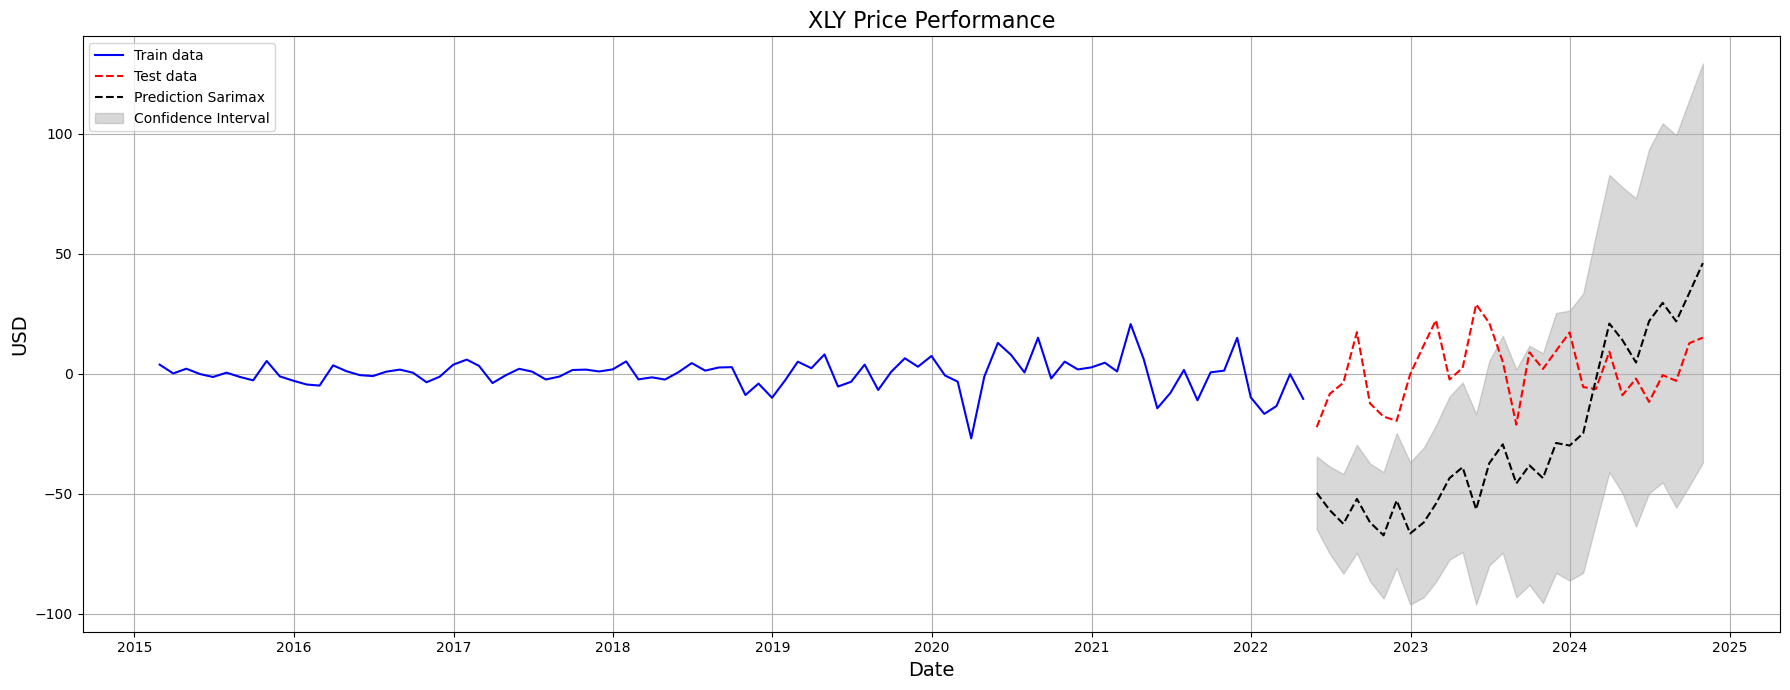

In [157]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(xly_train_data.index, xly_train_data, label='Train data', color='blue')
ax.plot(xly_pred_forecaster.index, xly_pred_forecaster['actual'], 'r--', label='Test data')
ax.plot(xly_pred_forecaster.index, xly_pred_forecaster['pred'], 'k--', label='Prediction Sarimax')

ax.fill_between(xly_pred_forecaster.index, xly_pred_forecaster['lower_bound'], xly_pred_forecaster['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('XLY Price Performance', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

In [159]:
# .predict() SARIMAX
# Defined the input variables
xly_pred_sarimax = prediction(prop,
                              xly_endog, 
                              exog_trim_aligned, 
                              xly_horizon, 
                              xly_order_forecaster, 
                              xly_seasonal_order_forecaster)
xly_pred_sarimax

,predicted_mean,lower_bound,upper_bound,actual
2022-05-31,-37.858342,-49.070473,-26.646212,-22.202743
2022-06-30,-39.365238,-51.161355,-27.569120,-8.322186
2022-07-31,-41.437967,-53.493967,-29.381967,-3.716786
2022-08-31,-34.536886,-46.789148,-22.284624,17.391791
2022-09-30,-47.404331,-61.329663,-33.478998,-12.317599
2022-10-31,-43.729349,-58.321507,-29.137191,-17.804101
2022-11-30,-41.445970,-56.463992,-26.427947,-19.565589
2022-12-31,-51.273147,-66.640216,-35.906078,-0.146837
2023-01-31,-51.165033,-67.317335,-35.012731,11.886196
2023-02-28,-52.789092,-69.521042,-36.057143,22.368879


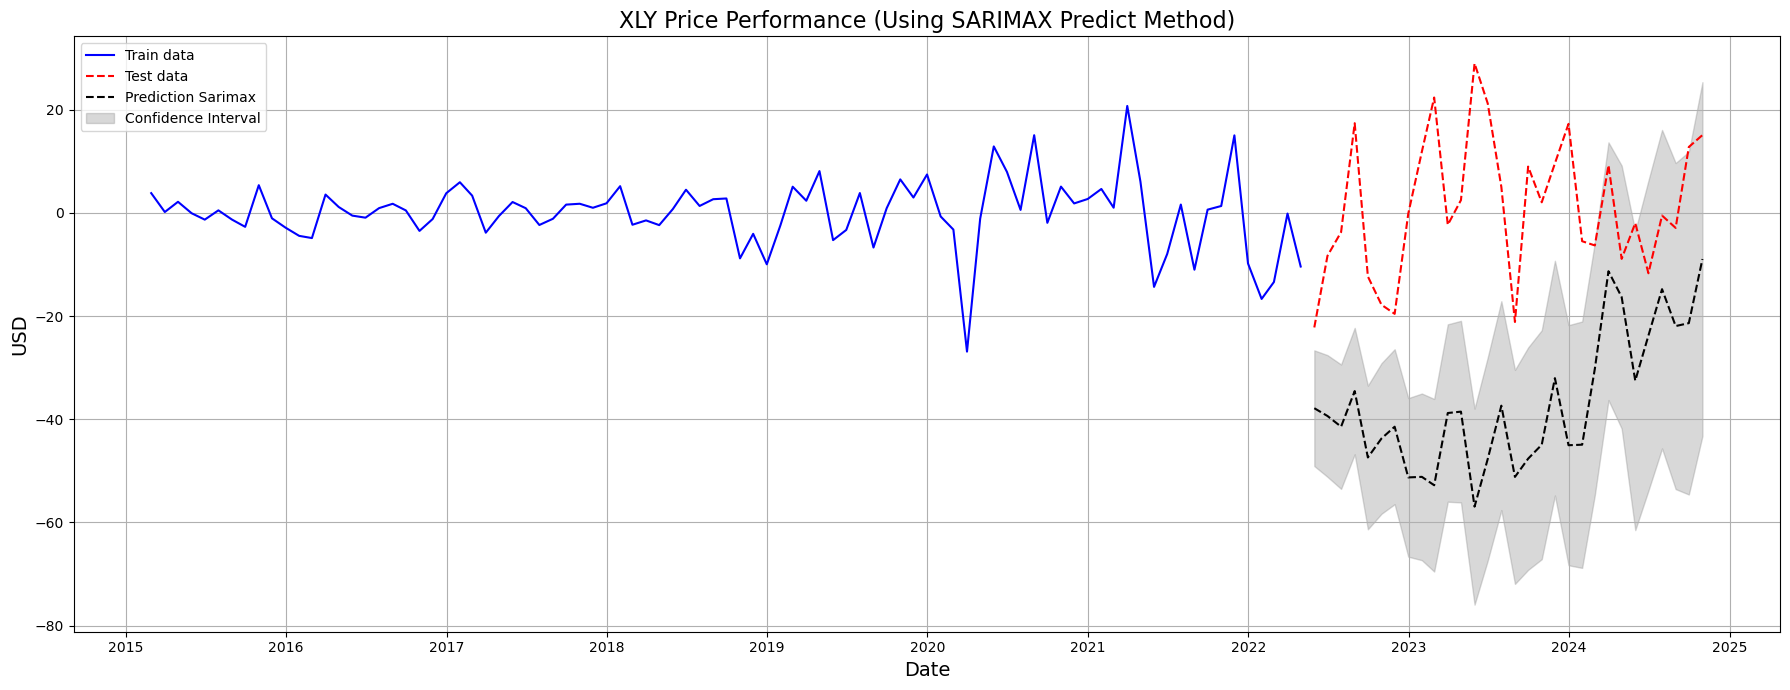

In [161]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(xly_train_data.index, xly_train_data, label='Train data', color='blue')
ax.plot(xly_pred_sarimax.index, xly_pred_sarimax['actual'], 'r--', label='Test data')
ax.plot(xly_pred_sarimax.index, xly_pred_sarimax['predicted_mean'], 'k--', label='Prediction Sarimax')

ax.fill_between(xly_pred_sarimax.index, xly_pred_sarimax['lower_bound'], xly_pred_sarimax['upper_bound'], 
                color='grey', alpha=0.3, label='Confidence Interval')

ax.set_title('XLY Price Performance (Using SARIMAX Predict Method)', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

### Part 10: Model Accuracy Testing

In [163]:
# Forecaster
# Test for MAPE 
etfs_pred_model = {
    'IXN':ixn_pred_forecaster, 
    'VNQ':vnq_pred_forecaster,
    'XLE':xle_pred_forecaster,
    'XLF':xlf_pred_forecaster,
    'XLY':xly_pred_forecaster}

sarimax_accuracy_df = pd.DataFrame()

for item in etfs:
    y_true = etfs_pred_model[item]['actual']
    y_pred_sarima = etfs_pred_model[item]['pred']
   
    # MAPE calculation
    mape_sarima = np.mean(np.abs((y_true - y_pred_sarima)/y_true)) * 100

    # MAE calculation
    mae_sarima = np.mean(np.abs(y_true-y_pred_sarima))

    # RMSE calculation
    rmse_sarima = np.sqrt(np.mean((y_true - y_pred_sarima)**2))

    # MSE calculation
    mse_sarima = np.mean((y_true - y_pred_sarima)**2)

    accuracy_df = pd.DataFrame({'MAPE_SARIMAX': [mape_sarima],
                                'MAE_SARIMAX': [mae_sarima],
                                'RMSE_SARIMAX': [rmse_sarima],
                                'MSE_SARIMAX': [mse_sarima]
                               })
    sarimax_accuracy_df = pd.concat([sarimax_accuracy_df, accuracy_df], axis=0, ignore_index=True)

sarimax_accuracy_df.index = etfs_pred_model.keys()
sarimax_accuracy_df

,MAPE_SARIMAX,MAE_SARIMAX,RMSE_SARIMAX,MSE_SARIMAX
IXN,771.327251,14.373529,16.711168,279.263127
VNQ,829.330300,21.951408,25.943169,673.048010
XLE,993.705539,16.110346,19.068147,363.594218
XLF,1971.621117,8.297368,9.286352,86.236335
XLY,2215.042238,40.717467,45.508441,2071.018235


In [165]:
# SARIMAX .predict()
# Test for MAPE 
etfs_pred_sarimax_model = {
    'IXN':ixn_pred_sarimax, 
    'VNQ':vnq_pred_sarimax,
    'XLE':xle_pred_sarimax,
    'XLF':xlf_pred_sarimax,
    'XLY':xly_pred_sarimax}

sarimax_pred_accuracy_df = pd.DataFrame()

for item in etfs:
    y_true_1 = etfs_pred_sarimax_model[item]['actual']
    y_pred_sarima_1 = etfs_pred_sarimax_model[item]['predicted_mean']
   
    # MAPE calculation
    mape_sarimax_pred = np.mean(np.abs((y_true_1 - y_pred_sarima_1)/y_true_1)) * 100

    # MAE calculation
    mae_sarimax_pred = np.mean(np.abs(y_true_1 - y_pred_sarima_1))

    # RMSE calculation
    rmse_sarimax_pred = np.sqrt(np.mean((y_true_1 - y_pred_sarima_1)**2))

    # MSE calculation  
    mse_sarimax_pred = np.mean((y_true_1 - y_pred_sarima_1)**2)

    pred_accuracy_df = pd.DataFrame({'MAPE_SARIMAX': [mape_sarimax_pred],
                                'MAE_SARIMAX': [mae_sarimax_pred],
                                'RMSE_SARIMAX': [rmse_sarimax_pred],
                                'MSE_SARIMAX': [mse_sarimax_pred]
                               })
    sarimax_pred_accuracy_df = pd.concat([sarimax_pred_accuracy_df, pred_accuracy_df], axis=0, ignore_index=True)

sarimax_pred_accuracy_df.index = etfs_pred_sarimax_model.keys()
sarimax_pred_accuracy_df

,MAPE_SARIMAX,MAE_SARIMAX,RMSE_SARIMAX,MSE_SARIMAX
IXN,1034.197670,15.433074,16.409268,269.264070
VNQ,634.639783,16.349914,19.101556,364.869455
XLE,763.940045,17.214557,18.961455,359.536759
XLF,3296.075066,15.113634,15.656048,245.111835
XLY,1781.758648,38.208288,42.744415,1827.084980
